## imports

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from prediction_pipeline.preprocessing import *
#from prediction_pipeline.build_sysmex_features import *
#from prediction_pipeline.training import *
#from sklearn.manifold import TSNE
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.linear_model import LinearRegression
#from matplotlib.patches import Patch
%load_ext cython
from bgen.reader import BgenFile
import subprocess

In [2]:
#data_dir = "/Users/hippolyte/sysmex2pf/data"
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
training_data = "%s/training_exports" % data_dir
#FACS_cols = ["FSC","SSC","SFL","FSCW"]
FACS_cols = ["FSC","SSC","SFL"]
pheno_cols = ["ADP_FIB","CRP_FIB","TRAP_FIB","PAR1_FIB","PAR4_FIB"]
#pheno_cols = ["ADP","CRP","TRAP","PAR1","PAR4"]
covar_cols = ["MPV","PLT","PCT","PDW","IPF"]

# Load Sysmex data of PFC cohort

We load Sysmex data (cell-level measurements) and phenotypes (MPV, PLT, etc...)

## phenotypes

In [61]:
sys_phen = load_sys_phenotypes(data_dir)

602 candidates summary files
Initially 1068 rows, 643 unique IDs
Finally 642 rows, 642 unique IDs


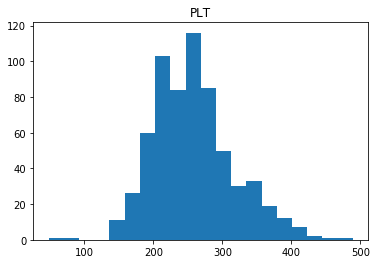

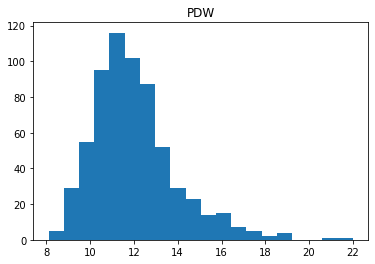

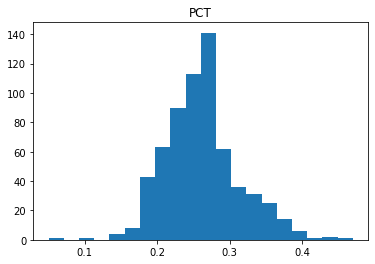

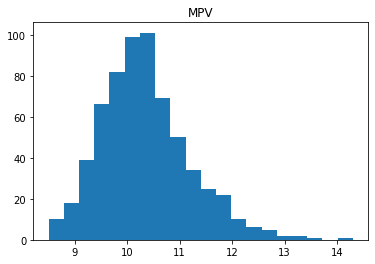

In [59]:
for col in ["PLT","PDW","PCT","MPV"]:
    plt.figure()
    plt.hist(sys_phen[col],bins=20)
    plt.title(col)

In [60]:
sys_phen.to_hdf("%s/sys_phen.hdf" % training_data, key="sys_phen")
print("Sysmex phenotypes available for %d samples" % sys_phen.shape[0])

Sysmex phenotypes available for 642 samples


## cell-level

In [61]:
sys_sct = load_Sysmex(data_dir)
sys_sct.rename(columns={"Side Fluorescence Signal":"SFL",
                                  "Forward Scatter Signal":"FSC",
                                  "Forward Scatter Pulse Width Signal":"FSCW",
                                  "Side Scatter Signal":"SSC"},inplace=True)

648 candidates Sysmex WB files


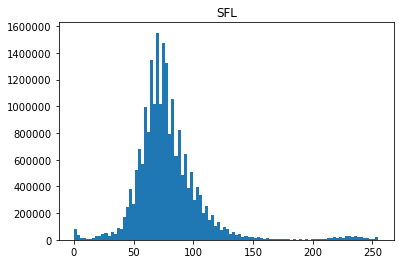

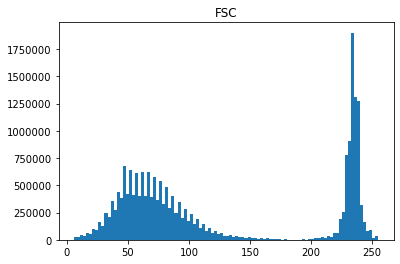

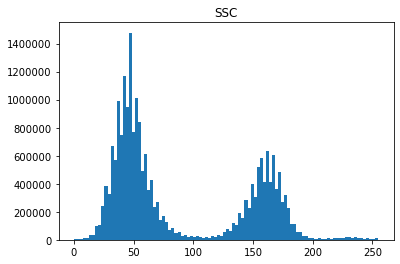

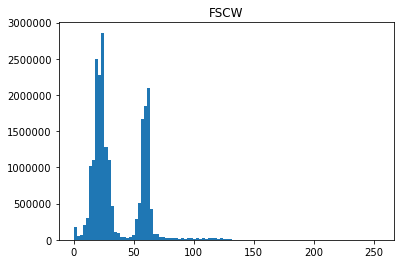

In [62]:
for c in sys_sct.columns[:4]:
    plt.figure()
    plt.hist(sys_sct[c],bins=100)
    plt.title(c)

In [63]:
sys_sct.to_hdf("%s/sys_df_init.hdf" % training_data,key="sys_df_init")

In [64]:
IDs_WB = sys_sct.ID.unique().tolist()
IDs_phen = sys_phen.ID.unique().tolist()

In [65]:
valid_IDs = [ID for ID in IDs_phen if ID in IDs_WB]
missing_IDs_1 = [ID for ID in IDs_phen if ID not in IDs_WB]
missing_IDs_2 = [ID for ID in IDs_WB if ID not in IDs_phen]
print("IDs in common", len(valid_IDs))
print("IDs only found in sysmex summary files", sorted(missing_IDs_1))
print("IDs only found in sysmex .FCS files", sorted(missing_IDs_2))

IDs in common 639
IDs only found in sysmex summary files ['C1A0NU', 'C1A0PQ', 'C1A2JU']
IDs only found in sysmex .FCS files ['C19BQP']


# Load Sysmex data of INTERVAL cohort

## Phenotypes

In [4]:
INTERVAL_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only"
meta = pd.read_csv("%s/interval_HAAS/meta_table.tsv" % INTERVAL_path, sep="\t")
pheno = pd.read_csv("%s/interval_phenotypes/INTERVALdata_14MAY2020.csv" % INTERVAL_path,sep=",", encoding = "ISO-8859-1")

In [5]:
print(meta.shape)
print(pheno.shape)

(112535, 11)
(48460, 760)


In [6]:
meta["valid_id"] = meta["EpiCovId_24m"]
meta = meta.loc[meta.SampleType == "NHSBT"]
meta.loc[~meta["EpiCovId_bl"].isnull(), "valid_id"] = meta.loc[~meta["EpiCovId_bl"].isnull(),"EpiCovId_bl"]
int_phen = pd.merge(meta, pheno, left_on="valid_id", right_on="identifier",how="inner")
int_phen.rename(columns={'PLT_10_9_L_bl':"PLT",'MPV_fL_bl':"MPV",'PCT_PCT_bl':"PCT",'PDW_fL_bl':"PDW","IPF_bl":"IPF"},inplace=True)
int_phen.dropna(subset=["PLT","MPV","PDW","PCT"],how="any",inplace=True)
int_phen["DateTime"] = pd.to_datetime(int_phen["DateTime"], format="%Y-%m-%d %H:%M:%S")
print("%d rows before removing duplicate IDs" % int_phen.shape[0])
int_phen = int_phen.sort_values("DateTime",ascending=True).drop_duplicates("valid_id",keep="first")
int_phen = int_phen.sort_values("DateTime",ascending=True).drop_duplicates("SampleNo",keep="first")
print("%d rows after removing duplicate IDs" % int_phen.shape[0])


52036 rows before removing duplicate IDs
38750 rows after removing duplicate IDs


NameError: name 'sys_phen' is not defined

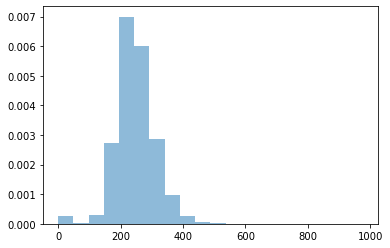

In [7]:
for c in ["PLT","MPV","PDW","PCT","IPF"]:
    plt.figure()
    plt.hist(int_phen[c],bins=20,density=True,alpha=.5,label="INTERVAL")
    plt.hist(sys_phen[c],bins=20,density=True,alpha=.5,label="Training cohort")
    plt.title(c)
    plt.legend()

## Cell level

In [70]:
sysmex_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_HAAS"
files = glob.glob("%s/*/SCT/PLTF*.csv" % sysmex_dir)

In [71]:
to_read = [[sysmex_dir + "/" + m + "/SCT/PLTF_" + f + ".csv" for f in \
           int_phen.loc[int_phen.FileName.str.contains(m,regex=False),"FileName"].tolist()] \
               for m in int_phen.Instrument.unique().tolist()]
to_read = to_read[0] + to_read[1]

print("Found %d scattergrams to read" % len(to_read))

Found 38750 scattergrams to read


In [72]:
dfs = []
# Only load a few examples, to check that clusterng will work well.
for f in tqdm(np.random.choice(to_read,200)):
    sct = pd.read_csv(f)
    assert sct.shape[0] > 0
    ID = f.split("][")[-1].lstrip(' ').split("]")[0]
    # Keeping only measurements with phase B
    #sct = sct.loc[sct.Phase == "B"]
    sct["ID"] = ID
    dfs.append(sct)
int_sct = pd.concat(dfs,axis=0,ignore_index=True)

100%|██████████| 200/200 [00:02<00:00, 83.72it/s]


# Filter platelets

## Polygon in SFL/FSC plane

In [73]:
def polygon_with_offset(offset):
    alpha = ((120+.6*offset) - (25+ .5*offset)) / (85 - 25)
    
    p = np.array([[22,25,30,85 ,140,200,200,80,50,22],
                  [5 + .3*offset ,25+ .5*offset,max(35+.5*offset,25+.5*offset + alpha*5),120+.6*offset,180+.6*offset,220,160,15,0,5+ .3*offset]])
    #p[0] -= offset
    return p.T

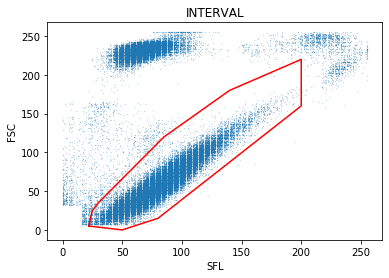

In [74]:
plt.figure()
sub_int_sct = int_sct.sample(int(1e5))
plt.scatter(sub_int_sct.SFL,
            sub_int_sct.FSC,s=.01)

offset = 0
polygon = polygon_with_offset(offset)
path = mplPath.Path(polygon)

plt.plot(polygon[:,0],polygon[:,1],c="red")

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.title("INTERVAL");

Text(0.5, 1.0, 'PFC Cohort')

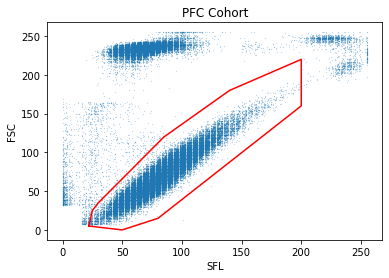

In [75]:
plt.figure()
sub_sys_sct = sys_sct.sample(int(1e5))
plt.scatter(sub_sys_sct.SFL,sub_sys_sct.FSC,s=.01)

offset = 0
polygon = polygon_with_offset(offset)
path = mplPath.Path(polygon)

plt.plot(polygon[:,0],polygon[:,1],c="red")

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.title("PFC Cohort")

In [76]:
int_sct["PLT"] = path.contains_points(int_sct[["SFL","FSC"]])
sys_sct["PLT"] = path.contains_points(sys_sct[["SFL","FSC"]])

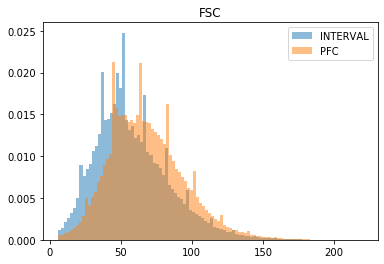

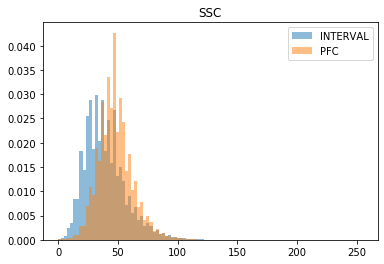

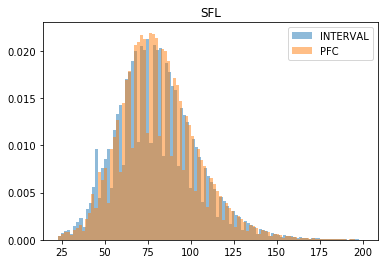

In [77]:
for c in FACS_cols:
    plt.figure()
    plt.hist(int_sct.loc[int_sct.PLT,c],bins=100,density=True,alpha=.5,label="INTERVAL")
    plt.hist(sys_sct.loc[sys_sct.PLT,c],bins=100,density=True,alpha=.5,label="PFC")
    plt.title(c)
    plt.legend()

Text(0, 0.5, 'SFL')

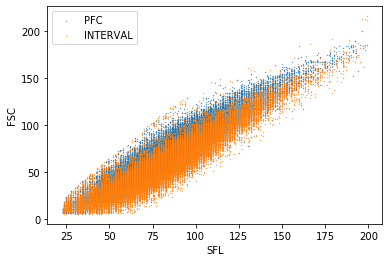

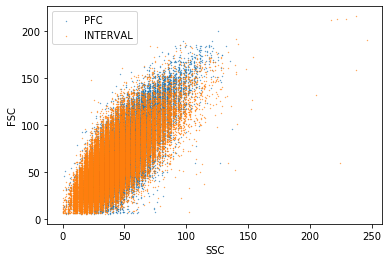

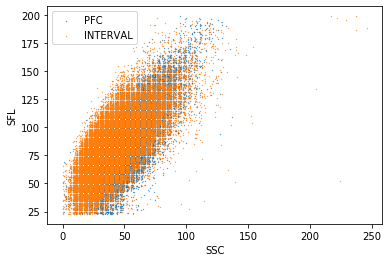

In [78]:
sub_sys_sct = sys_sct.sample(int(1e5))
sub_int_sct = int_sct.sample(int(1e5))
plt.figure()
plt.scatter(sub_sys_sct.loc[sub_sys_sct.PLT,"SFL"],sub_sys_sct.loc[sub_sys_sct.PLT,"FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct.loc[sub_int_sct.PLT,"SFL"],sub_int_sct.loc[sub_int_sct.PLT,"FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct.loc[sub_sys_sct.PLT,"SSC"],sub_sys_sct.loc[sub_sys_sct.PLT,"FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct.loc[sub_int_sct.PLT,"SSC"],sub_int_sct.loc[sub_int_sct.PLT,"FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct.loc[sub_sys_sct.PLT,"SSC"],sub_sys_sct.loc[sub_sys_sct.PLT,"SFL"],s=.1,label="PFC")
plt.scatter(sub_int_sct.loc[sub_int_sct.PLT,"SSC"],sub_int_sct.loc[sub_int_sct.PLT,"SFL"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("SFL")

## Compare counts

In [79]:
print(sys_sct.loc[sys_sct.PLT].ID.value_counts().mean())
print(int_sct.loc[int_sct.PLT].ID.value_counts().mean())

20864.878125
20921.6


Text(0.5, 1.0, 'PFC')

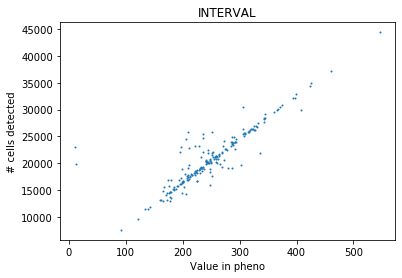

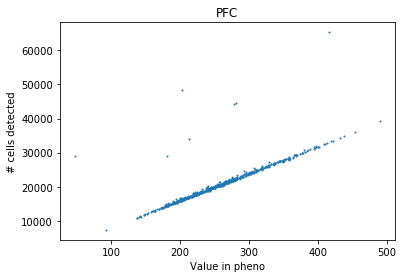

In [80]:
plt.figure()
X = pd.merge(int_phen,int_sct.loc[int_sct.PLT,"ID"].value_counts(),left_on="SampleNo",right_index=True)
plt.scatter(X["PLT"],X.ID,s=1)
plt.xlabel("Value in pheno")
plt.ylabel("# cells detected")
plt.title("INTERVAL")

plt.figure()
X = pd.merge(sys_phen,sys_sct.loc[sys_sct.PLT,"ID"].value_counts(),left_on="ID",right_index=True)
plt.scatter(X["PLT"],X.ID_y,s=1)
plt.xlabel("Value in pheno")
plt.ylabel("# cells detected")
plt.title("PFC")

## Filter for good

In [81]:
def read_and_filter_platelets(f):
    sct = pd.read_csv(f)
    assert sct.shape[0] > 0
    # Keeping only measurements with phase B
    ID = f.split("][")[-1].lstrip(' ').split("]")[0]
    #sct = sct.loc[sct.Phase == "B"]
    sct["PLT"] = path.contains_points(sct[["SFL","FSC"]])# & (sct["FSCW"] > 0)
    sct["ID"] = ID
    N = sct.PLT.sum()
    return sct.loc[sct.PLT,FACS_cols+["ID"]].sample(N // 4,replace=True)
    

In [82]:
from multiprocessing import Pool
p = Pool(16)
dfs = []
for df in tqdm(p.imap_unordered(read_and_filter_platelets,to_read)):
    dfs.append(df)
p.close()
int_sct = pd.concat(dfs,axis=0,ignore_index=True,copy=False)
del dfs

38750it [01:05, 588.46it/s]


In [83]:
int_sct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201640922 entries, 0 to 201640921
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   FSC     int64 
 1   SSC     int64 
 2   SFL     int64 
 3   ID      object
dtypes: int64(3), object(1)
memory usage: 6.0+ GB


In [84]:
int_sct.to_hdf("%s/int_sct_raw.hdf" % training_data,key="INT_SCT")
int_sct = pd.read_hdf("%s/int_sct_raw.hdf" % training_data,key="INT_SCT")

## Filter bad counts

In [85]:
from sklearn.linear_model import LinearRegression

In [86]:
count = sys_sct.groupby("ID")[["FSC"]].count().rename(columns={"FSC":"PLT_count"})
pheno = sys_phen.groupby("ID")[["PLT"]].first().rename(columns={"PLT":"PLT_pheno"})
comp_sys = pd.merge(count,pheno,left_index=True,right_index=True,how="inner")

count = int_sct.groupby("ID")[["FSC"]].count().rename(columns={"FSC":"PLT_count"})
pheno = int_phen.groupby("SampleNo")[["PLT"]].first().rename(columns={"PLT":"PLT_pheno"})
comp_int = pd.merge(count,pheno,left_index=True,right_index=True,how="inner")

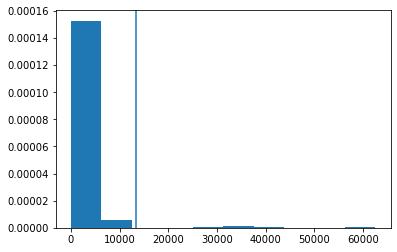

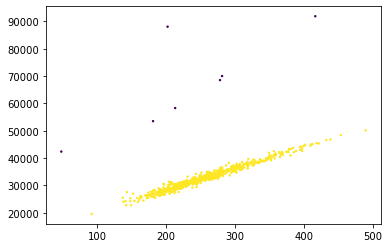

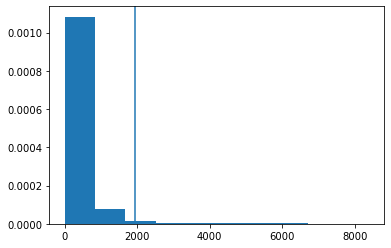

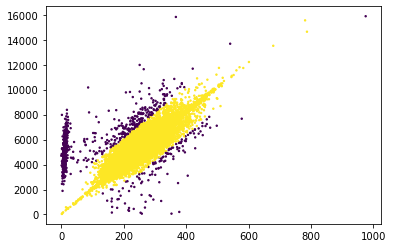

In [87]:
valid_IDs_PLT = []
for comp in [comp_sys,comp_int]:
    lm = LinearRegression(fit_intercept=False).fit(np.reshape(comp.PLT_pheno.values,(-1,1)),comp.PLT_count)
    pred = lm.predict(np.reshape(comp.PLT_pheno.values,(-1,1)))
    error = np.abs(pred-comp.PLT_count)
    plt.figure()
    plt.hist(error,density=True)
    err_threshold = np.mean(error) + 2.5*np.std(error)
    comp["err"] = error
    comp["err_th"] = error / comp.PLT_count
    comp["valid"] = (comp.err < err_threshold) & (comp.err_th < .6) 
    plt.axvline(err_threshold)
    plt.figure()
    plt.scatter(comp.PLT_pheno,comp.PLT_count,c=comp.valid,s=2)
    valid_IDs_PLT += comp.loc[comp.valid].index.tolist()

In [88]:
int_sct = int_sct.loc[int_sct.ID.isin(valid_IDs_PLT)]
sys_sct = sys_sct.loc[sys_sct.PLT]
sys_sct = sys_sct.loc[sys_sct.ID.isin(valid_IDs_PLT)]

int_sct.to_hdf("%s/int_sct_filtered.hdf" % training_data,key="INT_SCT")
sys_sct.to_hdf("%s/sys_sct_filtered.hdf" % training_data,key="SYS_SCT")

int_sct = pd.read_hdf("%s/int_sct_filtered.hdf" % training_data,key="INT_SCT")
sys_sct = pd.read_hdf("%s/sys_sct_filtered.hdf" % training_data,key="SYS_SCT")

In [89]:
sys_sct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13044506 entries, 0 to 38773
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   SFL     float32
 1   FSC     float32
 2   SSC     float32
 3   FSCW    float32
 4   ID      object 
 5   PLT     bool   
dtypes: bool(1), float32(4), object(1)
memory usage: 410.5+ MB


In [91]:
int_sct.ID.nunique()

37905

# Adjust

In [3]:
int_sct = pd.read_hdf("%s/int_sct_filtered.hdf" % training_data,key="INT_SCT")

## For time variations

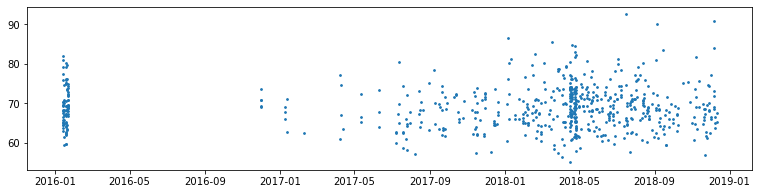

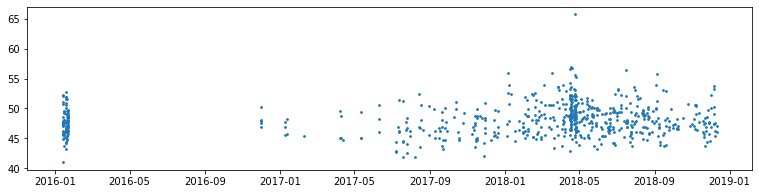

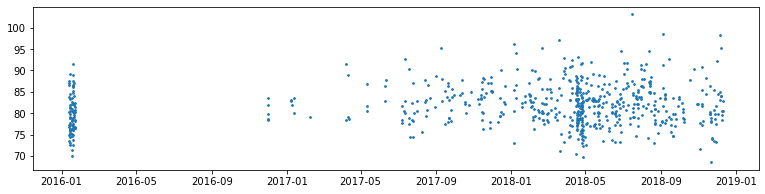

In [92]:
# No adjustment for PFC cohort, too few samples
mean_values = sys_sct.groupby("ID")[FACS_cols].mean()
mean_values = pd.merge(mean_values,sys_phen,left_index=True,right_on="ID")
for c in FACS_cols:
    plt.figure(figsize=(13,3))
    plt.scatter(pd.to_datetime(mean_values.Date),mean_values[c],s=3)

In [10]:
int_phen.head()

FileName         SampleNo  \
0  [XN-10^11041][00-11_8][20130301_101944][      ...  INT_116_6580100   
2  [XN-10^11041][00-11_8][20130301_102100][      ...  INT_116_6580000   
4  [XN-10^11041][00-11_8][20130301_102216][      ...  INT_116_2129800   
6  [XN-10^11041][00-11_8][20130301_102333][      ...  INT_116_4555900   
7  [XN-10^11041][00-11_8][20130301_102449][      ...  INT_116_4555800   

    Instrument            DateTime  DateTime_rank SampleType  \
0  XN-10^11041 2013-03-01 10:19:44            2.0      NHSBT   
2  XN-10^11041 2013-03-01 10:21:00            3.0      NHSBT   
4  XN-10^11041 2013-03-01 10:22:16            4.0      NHSBT   
6  XN-10^11041 2013-03-01 10:23:33            5.0      NHSBT   
7  XN-10^11041 2013-03-01 10:24:49            6.0      NHSBT   

   WithinSampleRank  EpiCovId_bl  EpiCovId_24m  EpiCovId_48m  ...  \
0                 1    1090916.0           NaN           NaN  ...   
2                 1    1111731.0           NaN           NaN  ...   
4                 1    1070498.0           NaN           NaN  ...   
6                 1    1042358.0           NaN           NaN  ...   
7                 1    1111391.0           NaN           NaN  ...   

   dateTRIG_48m  TCHOL_48m  CRP_48m  FERR_48m  FRUCTO_48m  HDL_48m  TRIG_48m  \
0           NaN        NaN      NaN       NaN         NaN      NaN       NaN   
2           NaN        NaN      NaN       NaN         NaN      NaN       NaN   
4           NaN        NaN      NaN       NaN         NaN      NaN       NaN   
6           NaN        NaN      NaN       NaN         NaN      NaN       NaN   
7           NaN        NaN      NaN       NaN         NaN      NaN       NaN   

  LDL_48m HBA1C_48m  HBF_48m  
0     NaN       NaN      NaN  
2     NaN       NaN      NaN  
4     NaN       NaN      NaN  
6     NaN       NaN      NaN  
7     NaN       NaN      NaN  

[5 rows x 772 columns]

In [ ]:
from pandas.tseries.offsets import MonthEnd
def compute_shift(x):
    #start = pd.to_datetime(x.index.max())
    #start = start + MonthEnd(0)
    #if start.month % 2 == 0:
    #    start = start + MonthEnd(1)
    #start = start.replace(second=0,hour=0,minute=0).to_datetime64()
    #print(start)
    #print()
    x = shift_by_month.loc[x.index.first(),x.name]
    return x

XN-10^11041 18772
XN-10^11036 19978


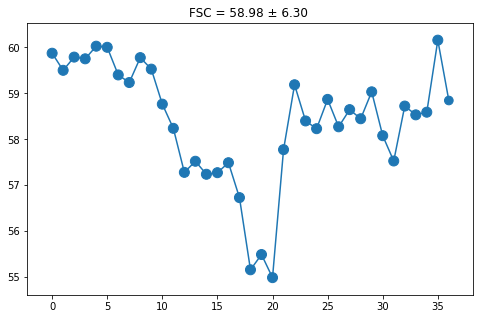

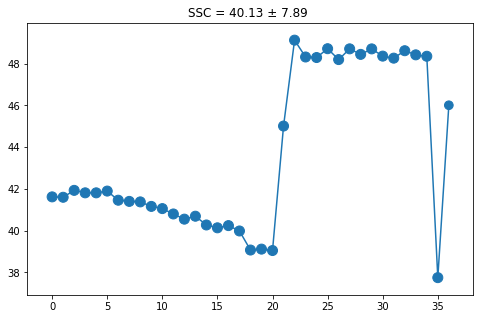

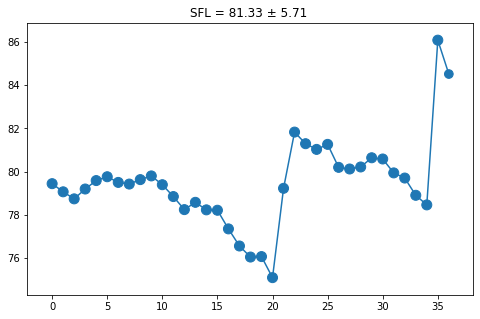

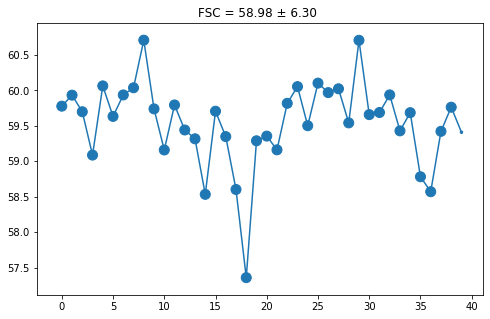

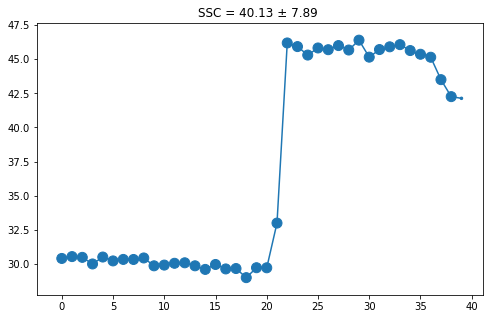

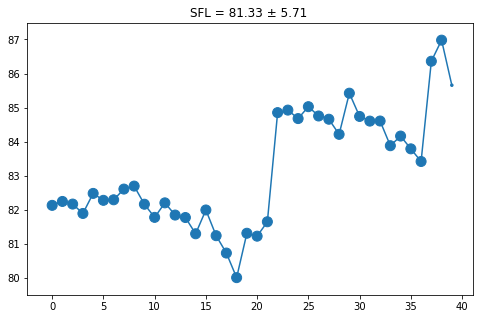

In [24]:
mean_values_all = int_sct.groupby("ID")[FACS_cols].mean()
base_mean = mean_values_all[FACS_cols].mean()
base_std = mean_values_all[FACS_cols].std()

sample_shifts = []
for machine in int_phen.Instrument.unique():
    
    machine_IDs = int_phen.loc[int_phen.Instrument == machine,"SampleNo"].unique().tolist()
    print(machine,len(machine_IDs))
    mean_values = int_sct.loc[int_sct.ID.isin(machine_IDs)].groupby("ID")[FACS_cols].mean()
    mean_values = pd.merge(mean_values,int_phen,left_index=True,right_on="SampleNo")
    mean_values.set_index("DateTime",inplace=True)
    mean_values.sort_index(inplace=True)
    mean_values.reset_index(inplace=True)
    mean_values["Group"] = mean_values.index // 500
    
    mean_counts = mean_values.groupby("Group")[FACS_cols].count()
    mean_val = mean_values.groupby("Group")[FACS_cols].mean()
    for c in mean_val.columns:
        plt.figure(figsize=(8,5))
        plt.plot(mean_val.index,mean_val[c])
        plt.scatter(mean_val.index,mean_val[c],s=mean_counts[c]/5)
        plt.title("%s = %.2f ± %.2f " % (c,base_mean[c],base_std[c]))
    shift_by_month = mean_val - base_mean
    shift_by_month.loc[mean_counts["FSC"] < 100] = np.nan
    shift_by_month.fillna(method="ffill",inplace=True,axis=0)
    sample_shift = pd.merge(mean_values[["Group","SampleNo"]],shift_by_month,left_on="Group",right_index=True)
    sample_shifts.append(sample_shift)
sample_shift = pd.concat(sample_shifts,axis=0)

In [26]:
sample_shift

Group         SampleNo       FSC       SSC       SFL
0          0  INT_116_6580100  0.889621  1.489046 -1.895418
1          0  INT_116_6580000  0.889621  1.489046 -1.895418
2          0  INT_116_2129800  0.889621  1.489046 -1.895418
3          0  INT_116_4555900  0.889621  1.489046 -1.895418
4          0  INT_116_4555800  0.889621  1.489046 -1.895418
...      ...              ...       ...       ...       ...
19526     39  INT_116_4461300  0.778310  2.125695  5.648027
19527     39  INT_116_7667600  0.778310  2.125695  5.648027
19528     39  INT_116_4510500  0.778310  2.125695  5.648027
19529     39  INT_116_4515800  0.778310  2.125695  5.648027
19530     39  INT_116_1952600  0.778310  2.125695  5.648027

[37905 rows x 5 columns]

In [27]:
offset = pd.merge(sample_shift,
                  int_phen,left_on="SampleNo",right_on="SampleNo",
                  how="inner")[["SampleNo"] + FACS_cols]

In [28]:
offset.set_index("SampleNo",inplace=True)
offset = offset.loc[~offset.index.duplicated(keep="first")]

In [29]:
shift = pd.merge(int_sct, offset,left_on="ID",
                 right_index=True,
                 suffixes=("","_shift"),
                 how="left")[[f+"_shift" for f in FACS_cols]]

In [30]:
int_sct[FACS_cols] = int_sct[FACS_cols].values - shift.values

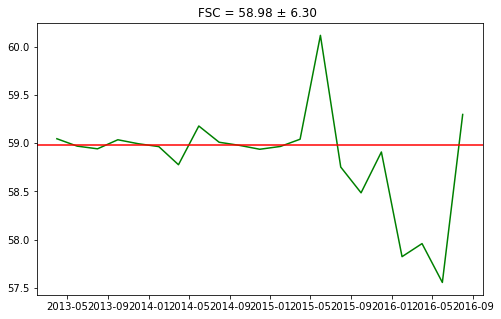

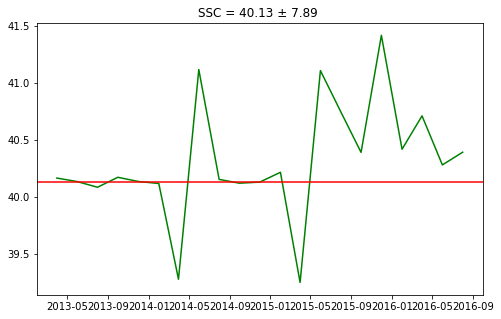

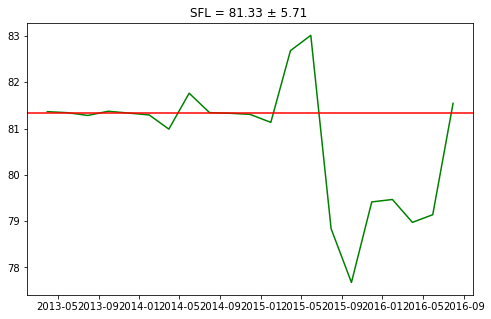

In [33]:
mean_values_post = int_sct.groupby("ID")[FACS_cols].mean()
mean_values_post = pd.merge(mean_values_post,int_phen,left_index=True,right_on="SampleNo")
mean_values_post.set_index("DateTime",inplace=True)
mean_val_post = mean_values_post.groupby((pd.Grouper(freq="2M")))[FACS_cols].mean()
for c in mean_val.columns:
    plt.figure(figsize=(8,5))
    plt.plot(mean_val_post.index,mean_val_post[c],c="green")
    plt.axhline(base_mean[c],c="red")
    #plt.scatter(mean_val.index,mean_val[c],s=mean_counts[c]/5)
    plt.title("%s = %.2f ± %.2f " % (c,base_mean[c],base_std[c]))

In [34]:
# IT works !

In [35]:
int_sct.to_hdf("%s/int_sct_adjusted.hdf" % training_data,key="INT_SCT")

## for discrepancies with PFC

In [36]:
int_sct = pd.read_hdf("%s/int_sct_adjusted.hdf" % training_data,key="INT_SCT")
sys_sct = pd.read_hdf("%s/sys_sct_filtered.hdf" % training_data)

Text(0, 0.5, 'SFL')

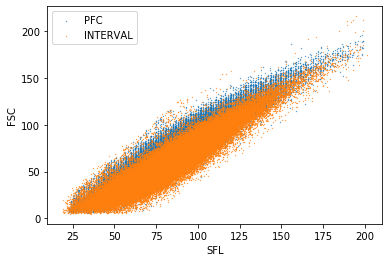

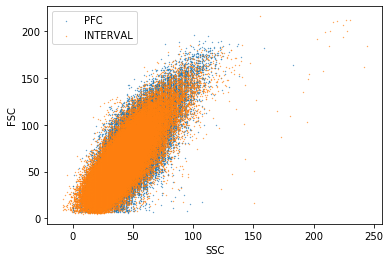

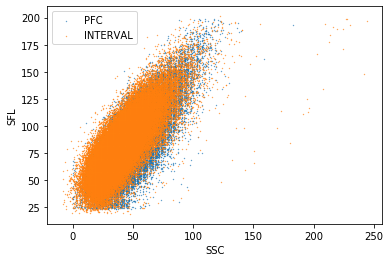

In [37]:
sub_sys_sct = sys_sct.sample(int(1e5))
sub_int_sct = int_sct.sample(int(1e5))
plt.figure()
plt.scatter(sub_sys_sct["SFL"],sub_sys_sct["FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SFL"],sub_int_sct["FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct["SSC"],sub_sys_sct["FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SSC"],sub_int_sct["FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct["SSC"],sub_sys_sct["SFL"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SSC"],sub_int_sct["SFL"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("SFL")

In [38]:
from scipy.interpolate import interp1d
for c in FACS_cols:
    pfc_quantiles = np.quantile(sys_sct[c],np.linspace(0,1,1000))
    int_quantiles = np.quantile(int_sct[c],np.linspace(0,1,1000))
    interpolator = interp1d(int_quantiles,pfc_quantiles)
    int_sct[c] = interpolator(int_sct[c])

Text(0, 0.5, 'SFL')

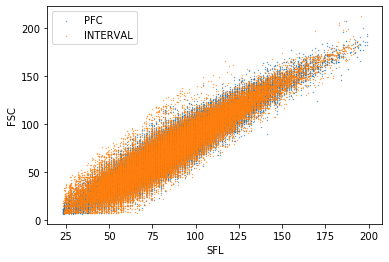

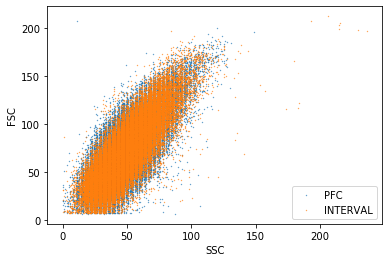

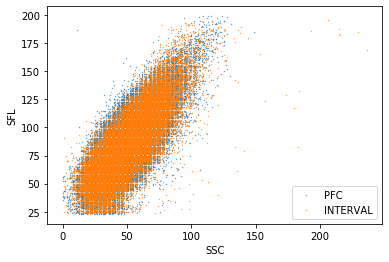

In [39]:
sub_sys_sct = sys_sct.sample(int(1e5))
sub_int_sct = int_sct.sample(int(1e5))
plt.figure()
plt.scatter(sub_sys_sct["SFL"],sub_sys_sct["FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SFL"],sub_int_sct["FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct["SSC"],sub_sys_sct["FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SSC"],sub_int_sct["FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct["SSC"],sub_sys_sct["SFL"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SSC"],sub_int_sct["SFL"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("SFL")

In [40]:
int_sct.to_hdf("%s/int_sct_discrepancy_adjusted.hdf" % training_data,key="INT_SCT")

# PF FC phenotypes

## Loading

We load the FC phenotypes database

In [44]:
all_pheno_df = pd.read_csv("%s/metadata_PF/PLATELET_FUNCTION_KD_11062019.txt" % data_dir,sep="\t")
#all_pheno_df.loc[all_pheno_df.PROJECT == "PFC_4_U","PROJECT"] = "PFC_4"
del all_pheno_df["TIME"]

pf_unicorn = pd.read_csv("%s/metadata_PF/UNICORN_PF.csv" % data_dir,sep=";",decimal=",")
pf_unicorn.dropna(subset=["ID"],how="any",axis=0,inplace=True)
pf_unicorn["PROJECT"] = "PFC_4_U2"
rename = {"Date":"DATE", "ID":"SAMPLE_ID"}
for c in pf_unicorn.columns:
    if c[-3:] == "_PP":
        rename[c] = c[:-3]
pf_unicorn.rename(columns=rename,inplace=True)
rename = {}
for c in pf_unicorn.columns:
    if c[:2] in ["F_","P_"]:
        pf_unicorn[c] = pf_unicorn[c].astype(float)
        parts = c.split("_")
        marker = parts[0]
        ago = parts[1]
        if marker == "F":
            marker = "FIB"
        elif marker == "P":
            marker = "PSEL"
        parts[1] = marker
        parts[0] = ago
        rename[c] = "_".join(parts)
pf_unicorn.rename(columns=rename,inplace=True)
good_columns = all_pheno_df.columns
pf_unicorn = pf_unicorn[good_columns]

In [45]:
all_pheno_df.sample(3)

PROJECT SAMPLE_ID      DATE  REST_FIB_1  REST_FIB_2  REST_PSEL_1  \
631     PFC_2       785  21/09/09        5.43        7.05         8.89   
1672  PFC_4_U    C0X075  20/01/16        2.06        1.16        15.29   
2103    PFC_4    C19YCZ  01/10/18        0.44        0.92        19.55   

      REST_PSEL_2  ADP_FIB_1  ADP_FIB_2  CRP_FIB_1  ...  PAR1_PSEL_1  \
631         12.24      44.57      48.46      41.49  ...          NaN   
1672        11.04      42.86      43.07      28.35  ...        82.32   
2103        21.22      51.90      51.49      26.86  ...        80.97   

      PAR1_PSEL_2  PAR4_FIB_1  PAR4_FIB_2  PAR4_PSEL_1  PAR4_PSEL_2  \
631           NaN         NaN         NaN          NaN          NaN   
1672        80.97       17.19       13.27        76.06        71.37   
2103        80.62       24.55       24.02        86.82        82.97   

      TRAP_FIB_1  TRAP_FIB_2  TRAP_PSEL_1  TRAP_PSEL_2  
631          NaN         NaN          NaN          NaN  
1672        1.81        2.44        32.39        30.62  
2103        2.15        1.63        44.43        40.61  

[3 rows x 27 columns]

In [46]:
#all_pheno_df = pd.concat([pf_unicorn,all_pheno_df],axis=0)

In [47]:
df = all_pheno_df.copy()

## QC of phenotypes

ADP - FIB : 2131
ADP - PSEL : 1686
CRP - FIB : 2134
CRP - PSEL : 2135
TRAP - FIB : 1186
TRAP - PSEL : 1186
PAR1 - FIB : 1184
PAR1 - PSEL : 1185
PAR4 - FIB : 1186
PAR4 - PSEL : 1185
Before Normalization
PROJECT
PFC_1     -1.098787
PFC_2     -0.550943
PFC_3     -2.035241
PFC_4     -0.065616
PFC_4_U   -0.130868
Name: ADP_FIB, dtype: float64
PROJECT
PFC_1      489
PFC_2      420
PFC_3      645
PFC_4      437
PFC_4_U     91
Name: ADP_FIB, dtype: int64
Before Normalization
PROJECT
PFC_1     -1.962329
PFC_3     -1.355818
PFC_4      1.148047
PFC_4_U    1.076130
Name: ADP_PSEL, dtype: float64
PROJECT
PFC_1      482
PFC_3      644
PFC_4      438
PFC_4_U     93
Name: ADP_PSEL, dtype: int64
Before Normalization
PROJECT
PFC_1     -0.424409
PFC_2     -1.482500
PFC_3     -0.104541
PFC_4     -0.769742
PFC_4_U   -1.078356
Name: CRP_FIB, dtype: float64
PROJECT
PFC_1      488
PFC_2      433
PFC_3      642
PFC_4      434
PFC_4_U     94
Name: CRP_FIB, dtype: int64
Before Normalization
PROJECT
PFC_1      0.

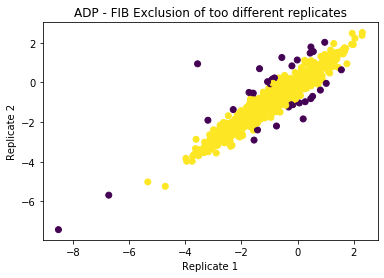

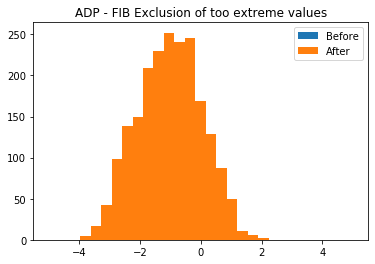

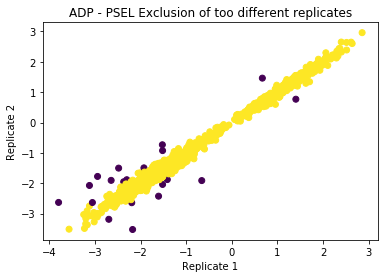

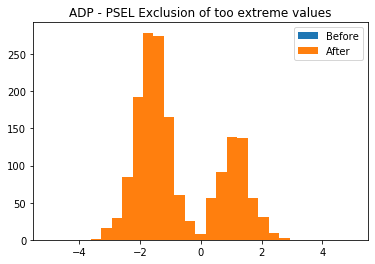

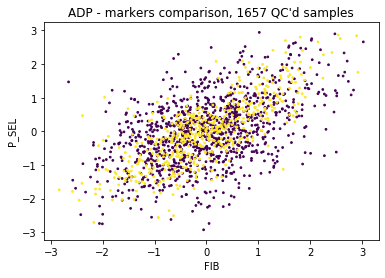

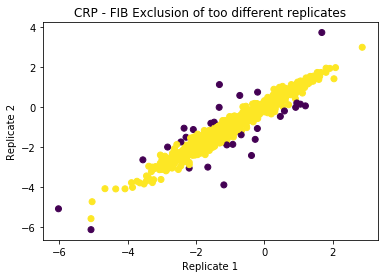

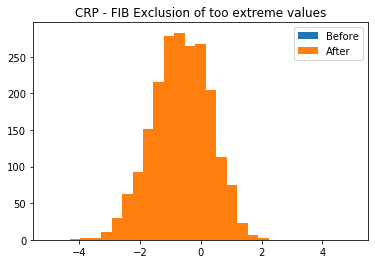

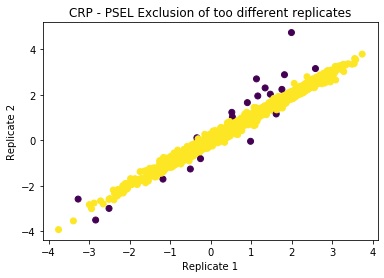

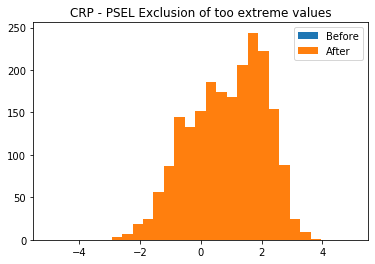

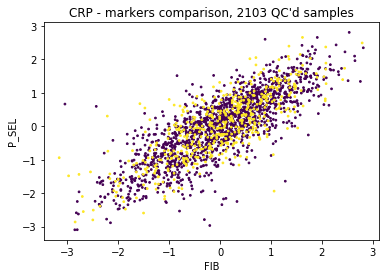

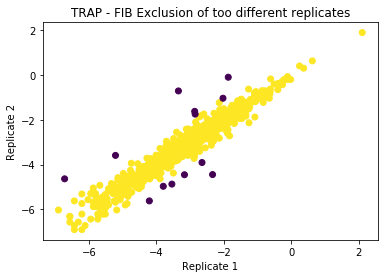

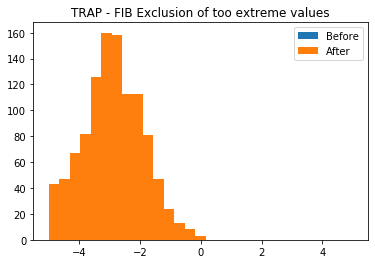

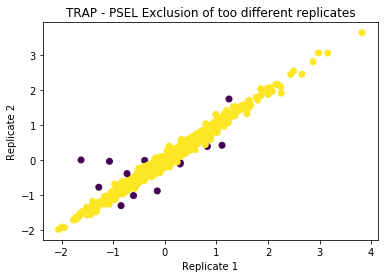

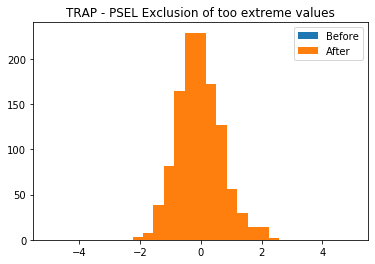

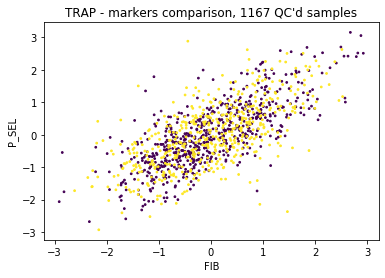

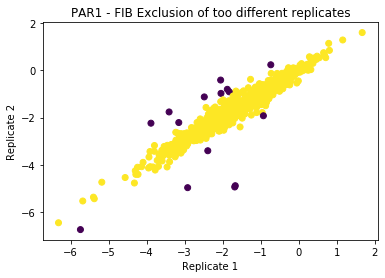

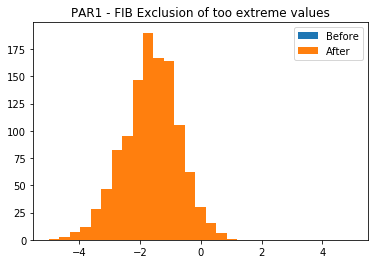

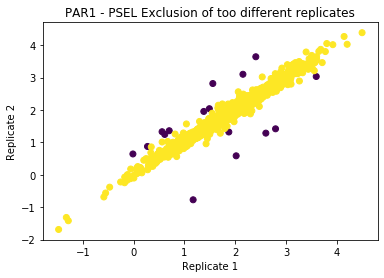

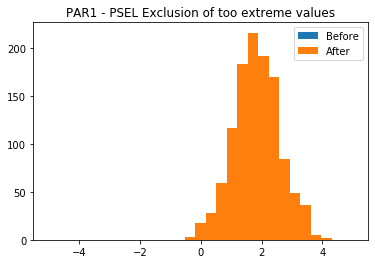

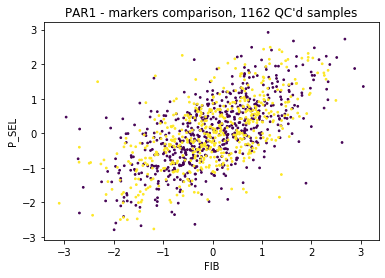

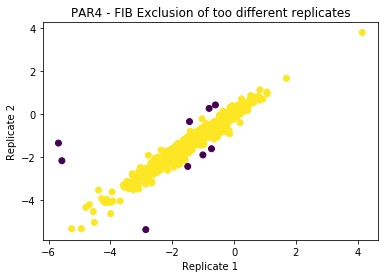

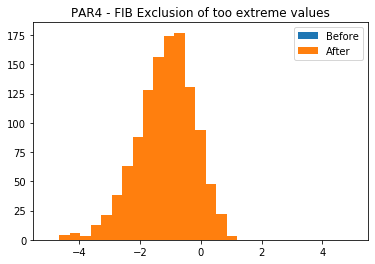

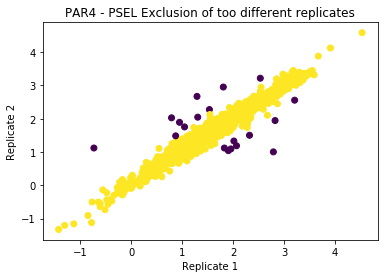

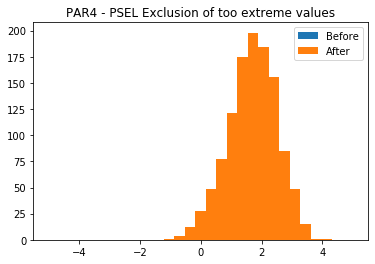

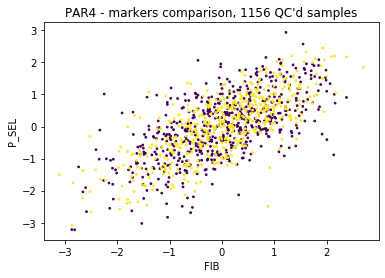

In [48]:
agonists = ["ADP","CRP","TRAP","PAR1","PAR4"]
for ago in agonists:
    for reag in ["FIB","PSEL"]:
        df["N_%s_%s" % (ago,reag)] = (1*~df["%s_%s_1" % (ago,reag)].isnull() + 1*~df["%s_%s_2" % (ago,reag)].isnull())
        # Do we check that there's at least one "REST" measurement ?
        # No ! This removed approx. 500 donors from the ADP cohort...
        # df["N_%s_%s" % (ago,reag)] *= 1*(~df["REST_%s_1"% reag].isnull() | ~df["REST_%s_2"% reag].isnull())
        df["OK_%s_%s" % (ago,reag)] = 1*(df["N_%s_%s" % (ago,reag)] == 2)
        print("%s - %s : %d" % (ago,reag, df["OK_%s_%s" % (ago,reag)].sum()))

# Move to logit

for c in df.columns:
    is_fc_measurement = False
    for ago in agonists + ["REST"]:
        if ago in str(c):
            is_fc_measurement = True
            break
    if is_fc_measurement == True:
        if df[c].dtype == np.float:
            df[c] = np.log(df[c] / (100. - df[c]))

# Actual QC

for ago in agonists:
    for marker in ["FIB", "PSEL"]:
        df["%s_%s_REP_DELTA" % (ago, marker)] = (df["%s_%s_1" % (ago, marker)] - df["%s_%s_2" % (ago, marker)])
        df["%s_%s_REP_OK" % (ago, marker)] = df["%s_%s_REP_DELTA" % (ago, marker)].abs() < 4*df["%s_%s_REP_DELTA" % (ago, marker)].abs().std()
        df["%s_%s" % (ago, marker)] = 0.5*(df["%s_%s_1" % (ago, marker)] + df["%s_%s_2" % (ago, marker)])
        plt.figure()
        plt.title("%s - %s Exclusion of too different replicates" % (ago, marker))
        plt.scatter(df.loc[df["OK_%s_%s" % (ago, marker)] == 1,"%s_%s_1" % (ago, marker)],
            df.loc[df["OK_%s_%s" % (ago, marker)] == 1,"%s_%s_2" % (ago, marker)],
            c = df.loc[df["OK_%s_%s" % (ago, marker)] == 1,"%s_%s_REP_OK" % (ago, marker)])
        plt.xlabel("Replicate 1")
        plt.ylabel("Replicate 2")

        df["%s_%s_VAL_OK" % (ago, marker)] = False
        for cohort in df.PROJECT.unique().tolist():
            inc_cond = (df["%s_%s_REP_OK" % (ago, marker)] == 1) & (df.PROJECT == cohort)
            df.loc[inc_cond,"%s_%s_VAL_OK" % (ago, marker)] = \
                (df.loc[inc_cond,"%s_%s" % (ago, marker)] - df.loc[inc_cond,"%s_%s" % (ago, marker)].mean()).abs() \
                < 3*df.loc[inc_cond,"%s_%s" % (ago, marker)].std()
        
        plt.figure()
        plt.title("%s - %s Exclusion of too extreme values" % (ago, marker))
            
        #b = np.linspace(df.loc[df["OK_%s_%s" % (ago, marker)]\
        #                *df["%s_%s_REP_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)].min()-1,
        #               df.loc[df["OK_%s_%s" % (ago, marker)]\
        #                *df["%s_%s_REP_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)].max()+1,30)

        b = np.linspace(-5,5,30)
        df["%s_%s_QC_OK" % (ago, marker)] = df["OK_%s_%s" % (ago, marker)]\
                        *df["%s_%s_REP_OK" % (ago, marker)]\
                        *df["%s_%s_VAL_OK" % (ago, marker)]
        df.loc[df["OK_%s_%s" % (ago,marker)]*\
                     df["%s_%s_QC_OK" % (ago,marker)] == 0,
                     "%s_%s" % (ago,marker)] = np.nan
        
        plt.hist(df.loc[df["OK_%s_%s" % (ago, marker)]\
                            *df["%s_%s_REP_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)],bins=b,label="Before")
        plt.hist(df.loc[df["OK_%s_%s" % (ago, marker)]\
                        *df["%s_%s_REP_OK" % (ago, marker)]\
                        *df["%s_%s_VAL_OK" % (ago, marker)] == 1,"%s_%s" % (ago, marker)],bins=b,label="After")
        plt.legend()

        print("Before Normalization")
        print(df.loc[df["%s_%s_QC_OK" % (ago, marker)] == True].groupby("PROJECT")["%s_%s" % (ago, marker)].mean())
        print(df.loc[df["%s_%s_QC_OK" % (ago, marker)] == True].groupby("PROJECT")["%s_%s" % (ago, marker)].count())
        
        for cohort in df.PROJECT.unique().tolist():
            cohort_valid_cond = ~df["%s_%s" % (ago,marker)].isnull() & (df.PROJECT == cohort)
            df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)] -= df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)].mean()
            df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)] /= df.loc[cohort_valid_cond,"%s_%s" % (ago,marker)].std()
    
    df[ago] = 0.5*(df["%s_%s" % (ago, "FIB")] + df["%s_%s" % (ago, "PSEL")])
    
    plt.figure()
    plt.title("%s - markers comparison, %d QC'd samples" % (ago, df["%s_%s_QC_OK" % (ago, marker)].sum()))
    plt.scatter(df.loc[df["%s_%s_QC_OK" % (ago, "FIB" )] & df["%s_%s_QC_OK" % (ago, "PSEL")] == True,"%s_%s" % (ago, "FIB")],
                df.loc[df["%s_%s_QC_OK" % (ago, "PSEL")] & df["%s_%s_QC_OK" % (ago, "FIB" )] == True,"%s_%s" % (ago, "PSEL")],
                c = df.loc[df["%s_%s_QC_OK" % (ago, "PSEL")] & df["%s_%s_QC_OK" % (ago, "FIB" )] == True,"PROJECT"].str.contains("4"),
                s=3)
    plt.xlabel("FIB")
    plt.ylabel("P_SEL")

## Adjust phenotypes

In [49]:
pheno_meta_df = pd.read_csv("%s/metadata_PF/PLATELET_FUNCTION_METADATA_KD_11062019.txt" % data_dir,sep="\t")

In [50]:
df = pd.merge(df,pheno_meta_df[["SAMPLE_ID","SEX","AGE","PLT","MPV"]],left_on="SAMPLE_ID",right_on="SAMPLE_ID")

### Sex

In [51]:
df.groupby("SEX")[["ADP","CRP","PAR1","PAR4","TRAP"]].mean()

ADP      CRP      PAR1      PAR4      TRAP
SEX                                                 
F   -0.049059 -0.03970  0.029172 -0.041867  0.014147
M    0.057448  0.03999 -0.012043  0.107828 -0.026578

No significant correlation with sex

### Age

In [53]:
from scipy.stats import pearsonr

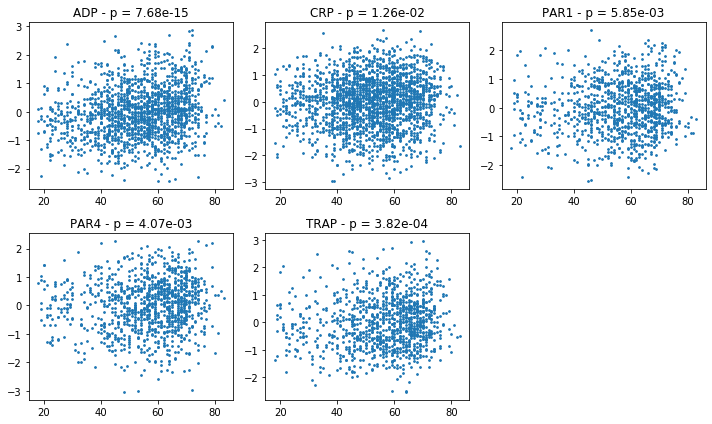

In [54]:
plt.figure(figsize=(10,6))
for i,pheno in enumerate(["ADP","CRP","PAR1","PAR4","TRAP"]):
    ax = plt.subplot(2,3,i+1)
    ax.scatter(df["AGE"],df[pheno],s=3)
    cond = ~(df.AGE.isnull() | df[pheno].isnull())
    stat = pearsonr(df.loc[cond,"AGE"], df.loc[cond,pheno])
    ax.set_title("%s - p = %.2e" % (pheno,stat[1]))
plt.tight_layout()

Since we observe significant correlations, we adjust phenotypes by Age

In [55]:
pheno_columns = ["ADP_PSEL","ADP_FIB","ADP",
               "CRP_PSEL","CRP_FIB","CRP",
               "TRAP_PSEL","TRAP_FIB","TRAP",
               "PAR1_PSEL","PAR1_FIB","PAR1",
               "PAR4_PSEL","PAR4_FIB","PAR4"]

In [56]:
for p in pheno_columns:
    cond = ~(df.AGE.isnull() | df[pheno].isnull())
    X = np.reshape(df.loc[cond,"AGE"].copy().values,(-1,1))
    Y = df.loc[cond,pheno].copy()
    lm = LinearRegression().fit(X,Y)
    Y_adjust = Y - lm.predict(X)
    df[pheno] = np.nan
    df.loc[cond,pheno] = Y_adjust

### Time

We look at a potential variation in time

In [57]:
df.DATE = pd.to_datetime(df.DATE,format="%d/%m/%y")
day_1_pfc_4 = df.loc[df.PROJECT == "PFC_4","DATE"].min()
df["DAYS"] = (df.DATE - day_1_pfc_4).dt.days

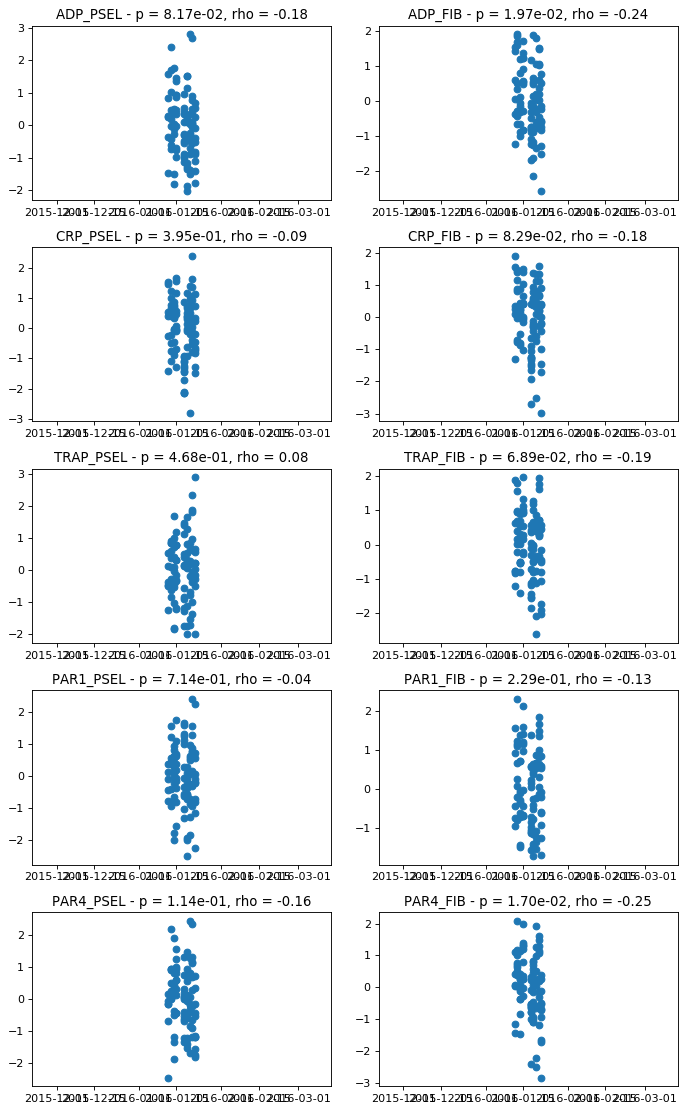

In [59]:
plt.figure(figsize=(13,14),dpi=80)
project = "PFC_4_U"
cond = df.PROJECT == project

for i, pheno in enumerate(pheno_columns):
    if "FIB" in pheno or "PSEL" in pheno:
        ax = plt.subplot(5,3,i+1)
        ax.scatter(df.loc[cond,"DATE"],df.loc[cond,pheno],label=project)
        ax.plot(df.loc[cond].groupby([pd.Grouper(key='DATE', freq='3M')])[pheno].mean(),color="red")
        cond_stat = cond & ~(df.DAYS.isnull() | df[pheno].isnull())
        stat = pearsonr(df.loc[cond_stat,"DAYS"], df.loc[cond_stat,pheno])
        ax.set_title("%s - p = %.2e, rho = %.2f" % (pheno,stat[1],stat[0]))
    
plt.tight_layout()

ADP_PSEL
ADP_FIB
ADP
CRP_PSEL
CRP_FIB
CRP
TRAP_PSEL
TRAP_FIB
TRAP
PAR1_PSEL
PAR1_FIB
PAR1
PAR4_PSEL
PAR4_FIB
PAR4


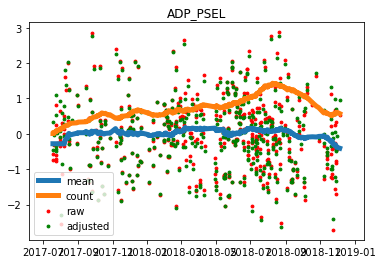

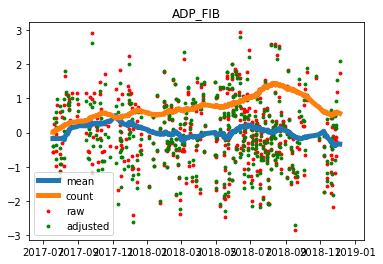

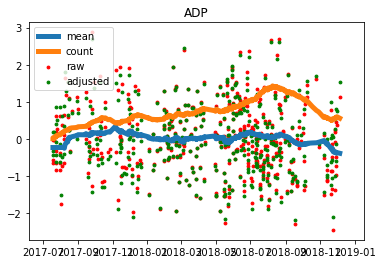

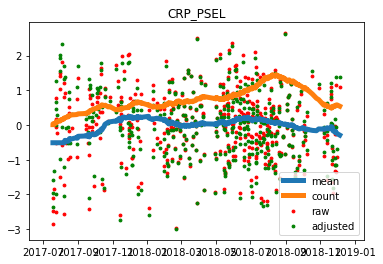

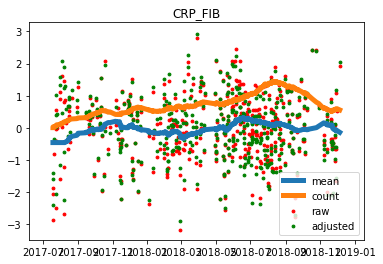

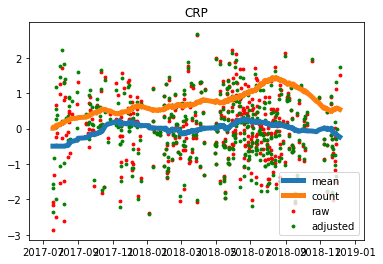

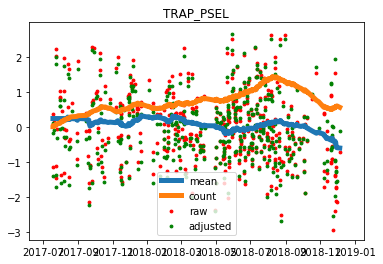

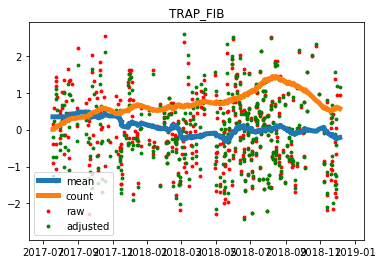

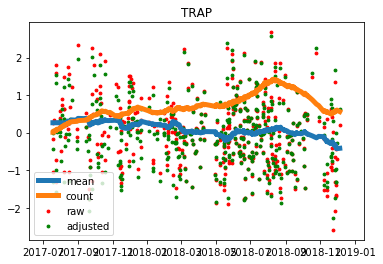

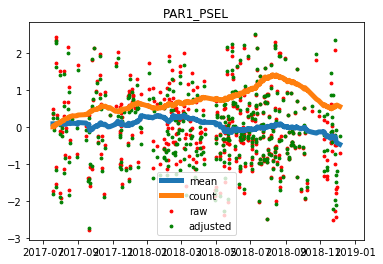

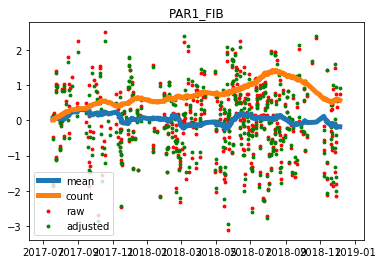

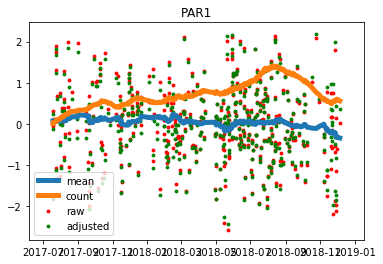

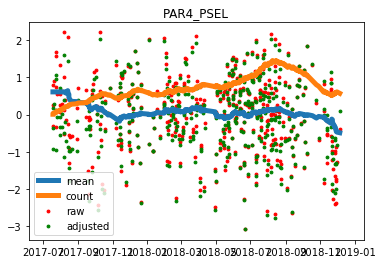

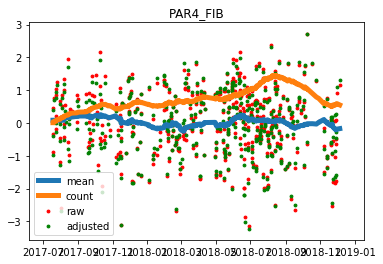

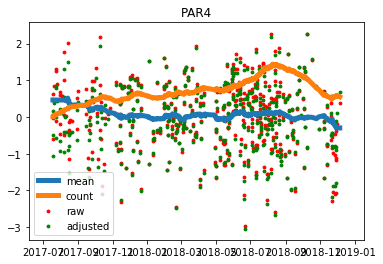

In [60]:
for p in pheno_columns:
    if p not in df.columns:
        continue
    print(p)
    # 45 days and min_count of 20 -> no improvement
    # SHould be improved, cluster points and apply adjustments on clusters.
    roll_count = df.loc[df.PROJECT == "PFC_4",[p,"DATE"]].rolling(window="90D",on="DATE").count()[p]
    roll_mean = df.loc[df.PROJECT == "PFC_4",[p,"DATE"]].rolling(window="90D",on="DATE").mean()[p]
    roll_mean.loc[roll_count < 20] = np.nan
    roll_mean = roll_mean.fillna(method="bfill")
    plt.figure()
    
    plt.scatter(df.loc[df.PROJECT == "PFC_4","DATE"],
                df.loc[df.PROJECT == "PFC_4",p],s=8,label="raw",c="red")
    plt.plot(df.loc[df.PROJECT == "PFC_4","DATE"],roll_mean,label="mean",lw=5)
    plt.plot(df.loc[df.PROJECT == "PFC_4","DATE"],roll_count/100,label="count",lw=5)
    
    df.loc[df.PROJECT == "PFC_4",p] -= roll_mean
    plt.scatter(df.loc[df.PROJECT == "PFC_4","DATE"],
                df.loc[df.PROJECT == "PFC_4",p],s=8,label="adjusted",c="green")
    plt.legend()
    plt.title(p)

## Summary of cohort sizes

In [61]:
for ago in agonists:
    for marker in ["FIB", "PSEL"]:
        print("%s - %s" % (ago, marker))
        print("Two replicates : \t\t%d" % df["OK_%s_%s" % (ago, marker)].sum())
        print("Coherent replicates : \t\t%d" % df["%s_%s_REP_OK" % (ago, marker)].sum())
        print("After outliers removal : \t%d" % df["%s_%s_VAL_OK" % (ago, marker)].sum())

df.loc[df.SAMPLE_ID.isin(sys_phen.ID.unique().tolist())].groupby("PROJECT")["SAMPLE_ID"].nunique()

ADP - FIB
Two replicates : 		2080
Coherent replicates : 		2044
After outliers removal : 	2031
ADP - PSEL
Two replicates : 		1635
Coherent replicates : 		1615
After outliers removal : 	1606
CRP - FIB
Two replicates : 		2084
Coherent replicates : 		2054
After outliers removal : 	2041
CRP - PSEL
Two replicates : 		2084
Coherent replicates : 		2064
After outliers removal : 	2052
TRAP - FIB
Two replicates : 		1136
Coherent replicates : 		1123
After outliers removal : 	1118
TRAP - PSEL
Two replicates : 		1136
Coherent replicates : 		1123
After outliers removal : 	1117
PAR1 - FIB
Two replicates : 		1134
Coherent replicates : 		1120
After outliers removal : 	1113
PAR1 - PSEL
Two replicates : 		1135
Coherent replicates : 		1119
After outliers removal : 	1112
PAR4 - FIB
Two replicates : 		1136
Coherent replicates : 		1128
After outliers removal : 	1120
PAR4 - PSEL
Two replicates : 		1135
Coherent replicates : 		1116
After outliers removal : 	1106


PROJECT
PFC_4      442
PFC_4_U     94
Name: SAMPLE_ID, dtype: int64

## Export phenotypes

In [62]:
pheno_df = df[["SAMPLE_ID"] + pheno_columns]
# TRAP AND PAR1 are very correlated, we create a phenotype with their average
pheno_df["TRAP_PAR1"] = 0.5*(pheno_df["TRAP"] + pheno_df["PAR1"])
pheno_df["TRAP_PAR1"] /= pheno_df["TRAP_PAR1"].std()
pheno_df["PSEL"] = pheno_df[[c for c in pheno_df.columns if "PSEL" in c]].mean(axis=1)
pheno_df["PSEL"] /= pheno_df.PSEL.std()
pheno_df["FIB"] = pheno_df[[c for c in pheno_df.columns if "FIB" in c]].mean(axis=1)
pheno_df["FIB"] /= pheno_df.FIB.std()

In [63]:
pheno_df.head()

SAMPLE_ID  ADP_PSEL   ADP_FIB       ADP  CRP_PSEL   CRP_FIB       CRP  \
0  100010100138  0.894928  0.331254  0.613091  0.005588  0.458084  0.231836   
1  100010100139  0.446127  0.121018  0.283572  1.550080  1.678134  1.614107   
2  100010100140  0.721840  0.416782  0.569311  0.475180  0.438540  0.456860   
3  100010100141 -1.345137  0.379559 -0.482789  0.651423  1.097282  0.874353   
4  100010100142 -0.872487 -1.989419 -1.430953 -0.031417 -0.560549 -0.295983   

   TRAP_PSEL  TRAP_FIB  TRAP  PAR1_PSEL  PAR1_FIB  PAR1  PAR4_PSEL  PAR4_FIB  \
0        NaN       NaN   NaN        NaN       NaN   NaN        NaN       NaN   
1        NaN       NaN   NaN        NaN       NaN   NaN        NaN       NaN   
2        NaN       NaN   NaN        NaN       NaN   NaN        NaN       NaN   
3        NaN       NaN   NaN        NaN       NaN   NaN        NaN       NaN   
4        NaN       NaN   NaN        NaN       NaN   NaN        NaN       NaN   

   PAR4  TRAP_PAR1      PSEL       FIB  
0   NaN        NaN  0.547899  0.470341  
1   NaN        NaN  1.214547  1.072056  
2   NaN        NaN  0.728300  0.509659  
3   NaN        NaN -0.422074  0.880002  
4   NaN        NaN -0.549960 -1.519443

In [64]:
print("# of samples in total %d" % pheno_df.shape[0])
pheno_df = pheno_df.loc[pheno_df.SAMPLE_ID.isin(sys_phen.ID.unique().tolist())]
pheno_df.set_index("SAMPLE_ID",inplace=True)
print("# of samples in Sysmex WB dataset %d" % pheno_df.shape[0])

# of samples in total 2091
# of samples in Sysmex WB dataset 536


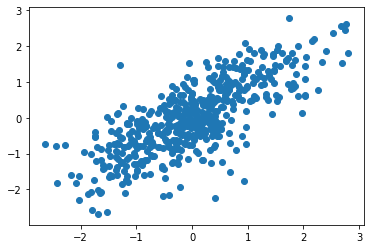

In [65]:
plt.scatter(pheno_df["ADP_PSEL"],pheno_df["ADP_FIB"])

In [66]:
pheno_df.to_hdf("%s/pheno_df.hdf" % training_data,key="pheno_df")
df.to_hdf("%s/df_all_columns.hdf" % training_data,key="all_columns")

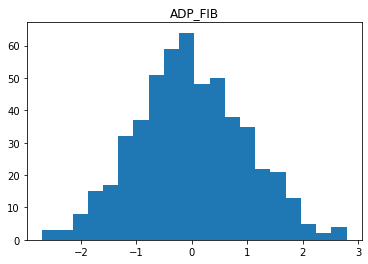

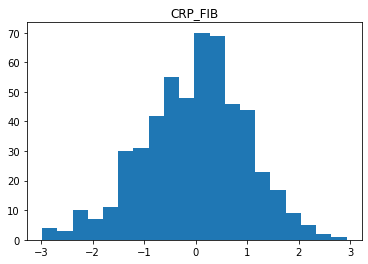

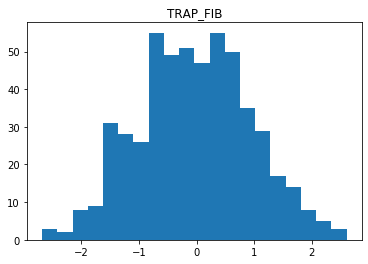

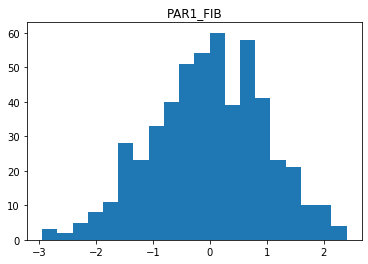

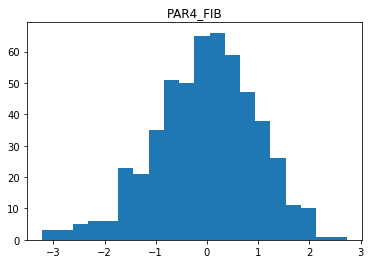

In [67]:
for c in pheno_cols:
    plt.figure()
    plt.hist(pheno_df[c],bins=20)
    plt.title(c)

# Prepare prediction input

In [41]:
int_sct = pd.read_hdf("%s/int_sct_discrepancy_adjusted.hdf" % training_data,key="INT_SCT")
sys_sct = pd.read_hdf("%s/sys_sct_filtered.hdf" % training_data)

In [42]:
df = pd.read_hdf("%s/df_all_columns.hdf" % training_data)

In [43]:
df.head()

PROJECT     SAMPLE_ID       DATE  REST_FIB_1  REST_FIB_2  REST_PSEL_1  \
0   PFC_1  100010100138 2005-01-08   -3.785213   -3.507485          NaN   
1   PFC_1  100010100139 2005-01-08   -3.403059   -3.532555          NaN   
2   PFC_1  100010100140 2005-01-08   -3.310875   -3.383977          NaN   
3   PFC_1  100010100141 2005-01-08   -3.799125   -3.500430          NaN   
4   PFC_1  100010100142 2005-01-08   -3.287572   -3.264763          NaN   

   REST_PSEL_2  ADP_FIB_1  ADP_FIB_2  CRP_FIB_1  ...  PAR4_PSEL_REP_OK  \
0          NaN  -0.812303  -0.937033   0.046408  ...             False   
1          NaN  -0.955899  -1.077919   0.957894  ...             False   
2          NaN  -0.737733  -0.895870  -0.106501  ...             False   
3          NaN  -0.978951  -0.705021   0.431367  ...             False   
4          NaN  -2.509426  -2.380136  -0.922740  ...             False   

   PAR4_PSEL  PAR4_PSEL_VAL_OK  PAR4_PSEL_QC_OK  PAR4  SEX   AGE     PLT  MPV  \
0        NaN             False                0   NaN    M  40.0  209.79  9.1   
1        NaN             False                0   NaN    M  55.0  251.97  7.8   
2        NaN             False                0   NaN    M  48.0  159.84  8.9   
3        NaN             False                0   NaN    M  34.0  208.68  9.3   
4        NaN             False                0   NaN    M  41.0  199.80  9.0   

   DAYS  
0 -4575  
1 -4575  
2 -4575  
3 -4575  
4 -4575  

[5 rows x 107 columns]

## Build features

### fit PCA

In [44]:
pca = PCA(whiten=True,n_components=2)

In [45]:
def sub_sample(df):
    return df.sample(3000)
X = sys_sct.groupby("ID")[FACS_cols].apply(sub_sample)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.91523481 0.05810363]


### Compute features

In [46]:
sct = pd.concat((sys_sct[FACS_cols + ["ID"]],int_sct[FACS_cols + ["ID"]]),axis=0)

In [47]:
X_t = pca.transform(sct[FACS_cols])

sct["X_0"] = X_t[:,0]
sct["X_1"] = X_t[:,1]
sct["X_0"] = np.clip(sct["X_0"],
                     np.quantile(sct["X_0"],0.001),
                     np.quantile(sct["X_0"],1-0.001))
sct["X_1"] = np.clip(sct["X_1"],
                     np.quantile(sct["X_1"],0.001),
                     np.quantile(sct["X_1"],1-0.001))
g = sct.groupby("ID")[["X_0","X_1"]]
mean = g.mean()
median = g.median()
upper = g.quantile(0.9)
lower = g.quantile(0.1)
std = g.std()
iqr = g.quantile(0.75) - g.quantile(0.25)
ratio_upper = np.log10(upper["X_1"] / upper["X_0"])
ratio_lower = np.log10(lower["X_1"] / lower["X_0"])
ratio_std = np.log10(std["X_1"] / std["X_0"])
skew = g.skew()

In [48]:
features = pd.concat([mean.rename(columns={"X_0":"mean_0","X_1":"mean_1"}),
           median.rename(columns={"X_0":"median_0","X_1":"median_1"}),
           upper.rename(columns={"X_0":"upper_0","X_1":"upper_1"}),
           lower.rename(columns={"X_0":"lower_0","X_1":"lower_1"}),
           std.rename(columns={"X_0":"std_0","X_1":"std_1"}),
           iqr.rename(columns={"X_0":"iqr_0","X_1":"iqr_1"}),
           skew.rename(columns={"X_0":"skew_0","X_1":"skew_1"}),
           pd.DataFrame(ratio_upper).rename(columns={0:"ratio_upper"}),
           pd.DataFrame(ratio_lower).rename(columns={0:"ratio_lower"}),
           pd.DataFrame(ratio_std).rename(columns={0:"ratio_std"})],axis=1)
features = features.dropna(how="any",axis=0)

In [49]:
features.head()

mean_0    mean_1  median_0  median_1   upper_0   upper_1   lower_0  \
ID                                                                             
C0WX4Z -0.019647 -0.037007 -0.122999 -0.062404  1.199414  1.225730 -1.103331   
C0WX6V -0.029607  0.015436 -0.126663 -0.015159  1.279308  1.240074 -1.215707   
C0WX7T  0.087157  0.141065  0.003254  0.126535  1.321487  1.390261 -1.033062   
C0WX8R  0.087554 -0.210461 -0.037007 -0.217126  1.436730  0.947462 -1.103628   
C0WXBL -0.064073 -0.081746 -0.153500 -0.089219  1.152934  1.107103 -1.171409   

         lower_1     std_0     std_1     iqr_0     iqr_1    skew_0    skew_1  \
ID                                                                             
C0WX4Z -1.283416  0.939136  1.006082  1.198910  1.294368  0.652950  0.261581   
C0WX6V -1.194827  1.015033  0.980897  1.296584  1.258072  0.675880  0.282746   
C0WX7T -1.104041  0.946243  0.981744  1.214740  1.295490  0.554986  0.096006   
C0WX8R -1.384424  1.038660  0.934770  1.324904  1.214207  0.731141  0.159694   
C0WXBL -1.268263  0.953627  0.949025  1.210623  1.218784  0.712063  0.164114   

        ratio_upper  ratio_lower  ratio_std  
ID                                           
C0WX4Z     0.009426     0.065662   0.029905  
C0WX6V    -0.013527    -0.007524  -0.014857  
C0WX7T     0.022034     0.028859   0.015996  
C0WX8R    -0.180813     0.098447  -0.045769  
C0WXBL    -0.017617     0.034501  -0.002101

### Filter and save

In [50]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38419 entries, C0WX4Z to INT_116_999400
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mean_0       38419 non-null  float64
 1   mean_1       38419 non-null  float64
 2   median_0     38419 non-null  float64
 3   median_1     38419 non-null  float64
 4   upper_0      38419 non-null  float64
 5   upper_1      38419 non-null  float64
 6   lower_0      38419 non-null  float64
 7   lower_1      38419 non-null  float64
 8   std_0        38419 non-null  float64
 9   std_1        38419 non-null  float64
 10  iqr_0        38419 non-null  float64
 11  iqr_1        38419 non-null  float64
 12  skew_0       38419 non-null  float64
 13  skew_1       38419 non-null  float64
 14  ratio_upper  38419 non-null  float64
 15  ratio_lower  38419 non-null  float64
 16  ratio_std    38419 non-null  float64
dtypes: float64(17)
memory usage: 5.3+ MB


In [51]:
features.to_hdf("%s/features.hdf" % training_data,key="features")

### Check discrepancies

In [52]:
pfc_IDs = sys_sct.ID.unique().tolist()

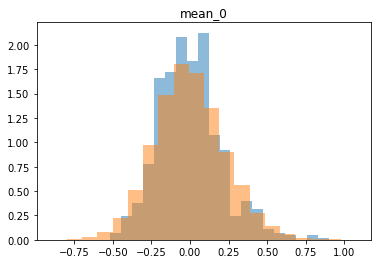

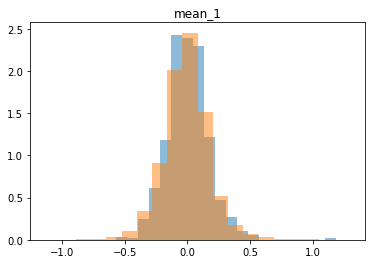

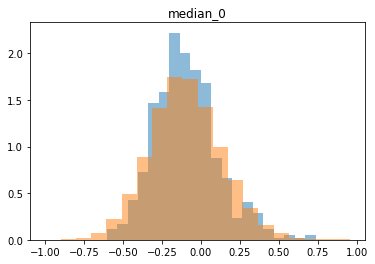

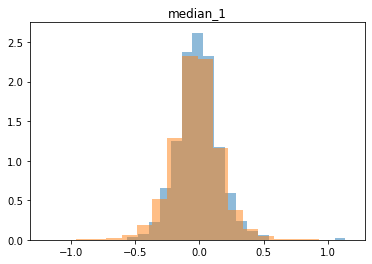

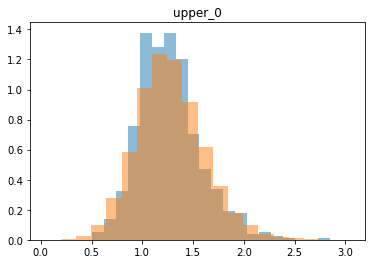

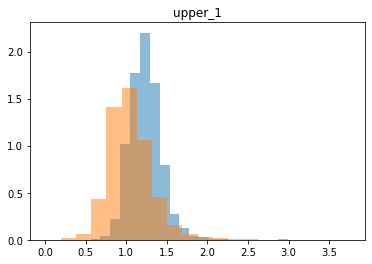

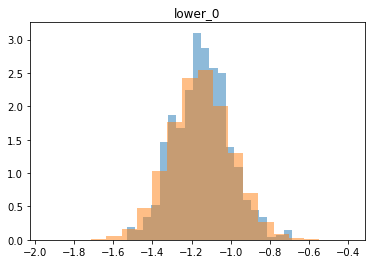

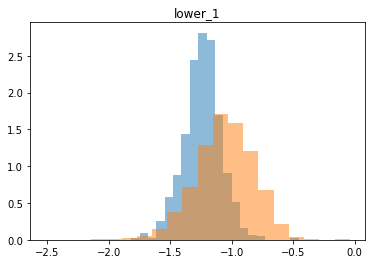

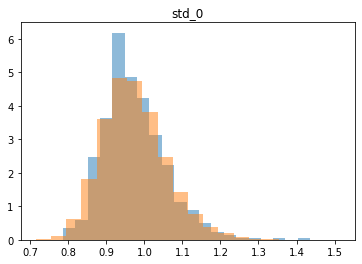

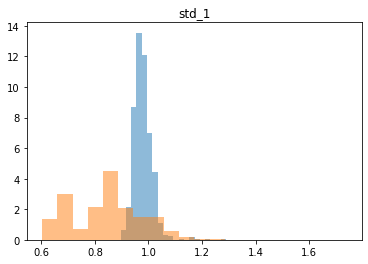

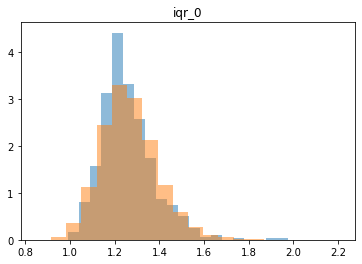

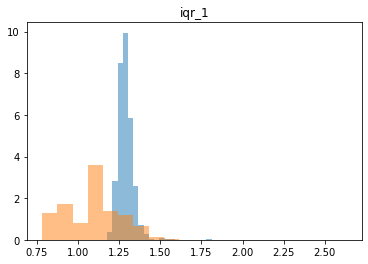

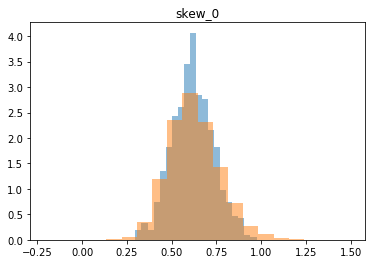

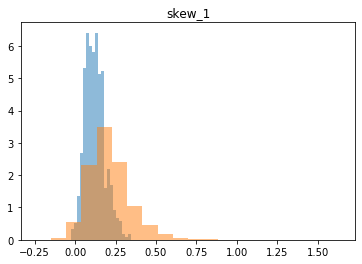

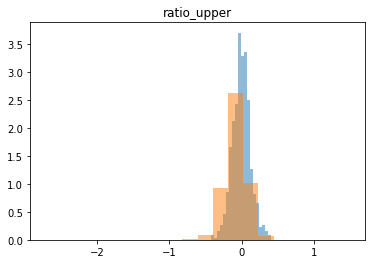

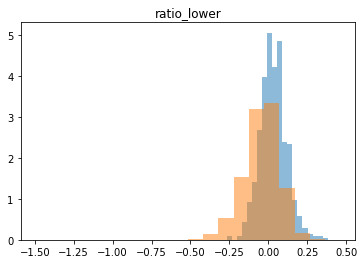

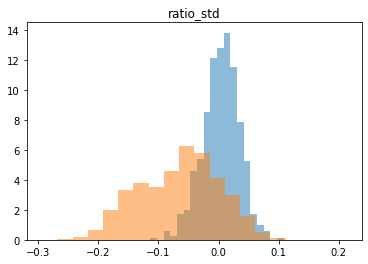

In [53]:
for f in features.columns:
    plt.figure()
    plt.hist(features.loc[ features.index.isin(pfc_IDs),f],density=True,bins=20,alpha=.5)
    plt.hist(features.loc[~features.index.isin(pfc_IDs),f],density=True,bins=20,alpha=.5)
    plt.title(f)

## Correct Sysmex discrepancies

In [54]:
# Approach : fit/transform gaussian quantile-norm on features, on PFC and INT seperately

In [55]:
from sklearn.preprocessing import quantile_transform
features.loc[features.index.isin(pfc_IDs)] = \
    quantile_transform(features.loc[features.index.isin(pfc_IDs)],
                    n_quantiles=50,output_distribution="normal")
features.loc[~features.index.isin(pfc_IDs)] = \
    quantile_transform(features.loc[~features.index.isin(pfc_IDs)],
                    n_quantiles=250,output_distribution="normal")

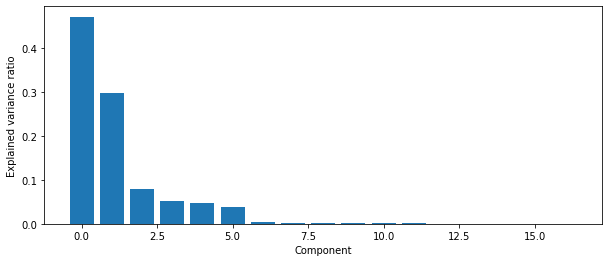

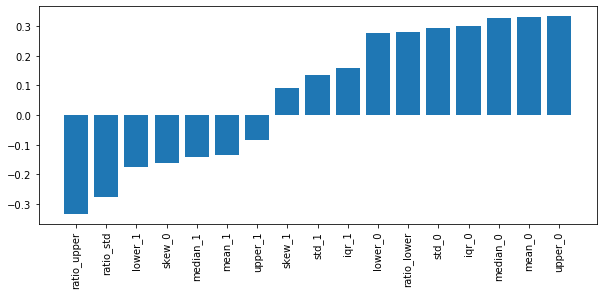

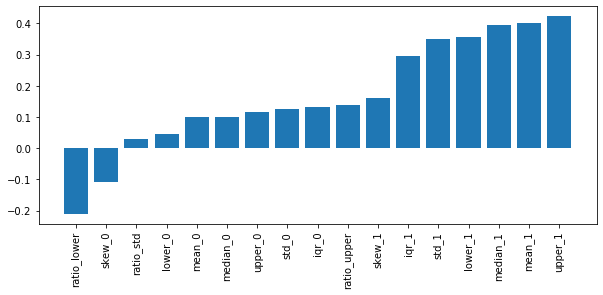

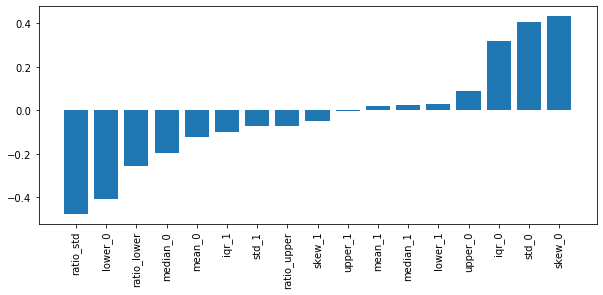

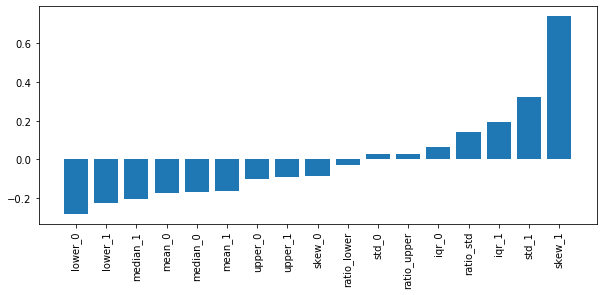

In [56]:
pca = PCA(whiten=True).fit(features.loc[features.index.isin(pfc_IDs)].values)
fig = plt.figure(figsize=(10,4))
e_var = pca.explained_variance_ratio_
plt.bar(np.arange(len(e_var)),e_var)
plt.xlabel("Component")
plt.ylabel("Explained variance ratio")
n_significant_comps = np.max(np.where(e_var > 0.05)[0])
for k in range(n_significant_comps +1):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    order = np.argsort(pca.components_[k])
    ax.bar(np.arange(len(e_var)),pca.components_[k,order])
    plt.xticks(np.arange(len(e_var)),features.columns[order],rotation='vertical')

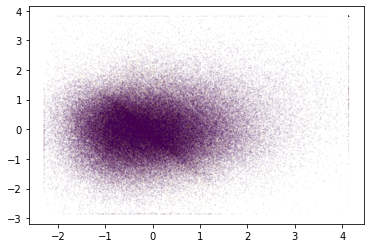

In [57]:
sub_X = sct.sample(int(2e5))
plt.scatter(sub_X["X_0"],sub_X["X_1"],c=sub_X.ID.isin(pfc_IDs),s=.001)

In [58]:
features.head()

mean_0    mean_1  median_0  median_1   upper_0   upper_1   lower_0  \
ID                                                                             
C0WX4Z -0.018365 -0.199784 -0.057999 -0.329510 -0.140684 -0.005128  0.320964   
C0WX6V -0.077066  0.124360 -0.080145 -0.015500  0.129664  0.064605 -0.497383   
C0WX7T  0.506687  0.945953  0.568119  0.946176  0.277084  0.900568  0.837391   
C0WX8R  0.509253 -1.326795  0.337843 -1.322122  0.692132 -1.638083  0.318690   
C0WXBL -0.233303 -0.525308 -0.233769 -0.507893 -0.281259 -0.743476 -0.186632   

         lower_1     std_0     std_1     iqr_0     iqr_1    skew_0    skew_1  \
ID                                                                             
C0WX4Z -0.363173 -0.334068  0.919636 -0.445841  0.270605  0.365082  1.968077   
C0WX6V  0.261751  0.634111  0.225017  0.492655 -0.692822  0.513333  2.142091   
C0WX7T  0.935710 -0.211571  0.248350 -0.252141  0.307055 -0.553136 -0.321735   
C0WX8R -1.054754  0.887369 -1.592102  0.705829 -2.075776  0.957673  0.687864   
C0WXBL -0.251968 -0.070730 -0.988085 -0.305855 -1.938590  0.811822  0.785619   

        ratio_upper  ratio_lower  ratio_std  
ID                                           
C0WX4Z     0.077078     0.420442   0.879569  
C0WX6V    -0.079348    -0.485993  -0.705754  
C0WX7T     0.188876    -0.005830   0.363484  
C0WX8R    -1.488318     0.809438  -1.545525  
C0WXBL    -0.111330     0.067314  -0.245271

In [59]:
sys_phen.head()

NameError: name 'sys_phen' is not defined

## Prepare covariates

In [ ]:
int_IDs = int_sct.ID.unique().tolist()

In [68]:
covar = pd.concat((int_phen.set_index("SampleNo")[covar_cols],
           sys_phen.set_index("ID")[covar_cols]),
          axis=0)
#covar = covar.loc[covar.index.isin(valid_IDs_PLT)]

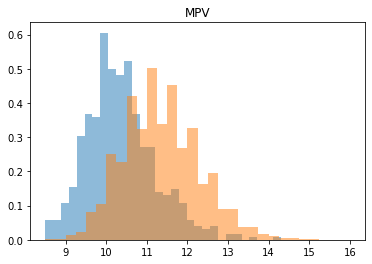

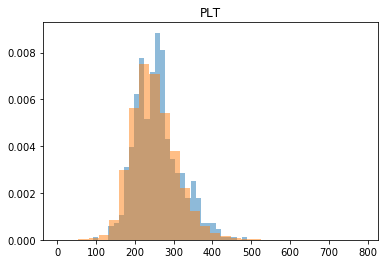

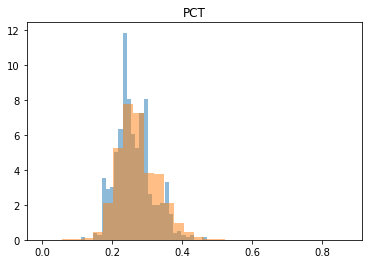

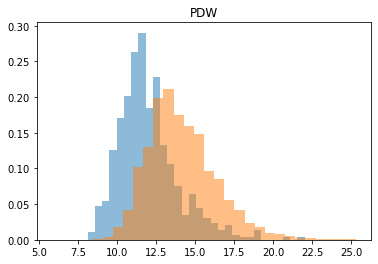

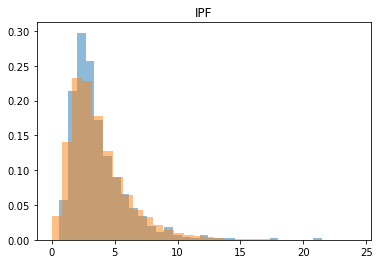

In [70]:
for c in covar.columns:
    plt.figure()
    plt.hist(covar.loc[covar.index.isin(pfc_IDs),c],density=True,alpha=.5,bins=30)
    plt.hist(covar.loc[covar.index.isin(int_IDs),c],density=True,alpha=.5,bins=30)
    plt.title(c)

In [71]:
# There are discrpancies, let's correct them the same way
covar.loc[covar.index.isin(pfc_IDs)] = \
    quantile_transform(covar.loc[covar.index.isin(pfc_IDs)],
                    n_quantiles=50,output_distribution="normal")
covar.loc[covar.index.isin(int_IDs)] = \
    quantile_transform(covar.loc[covar.index.isin(int_IDs)],
                    n_quantiles=2500,output_distribution="normal")

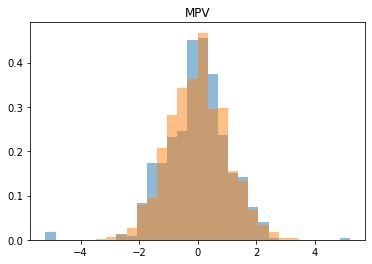

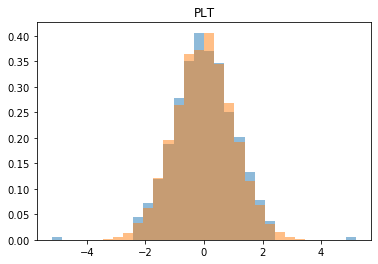

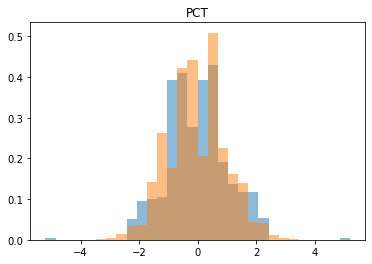

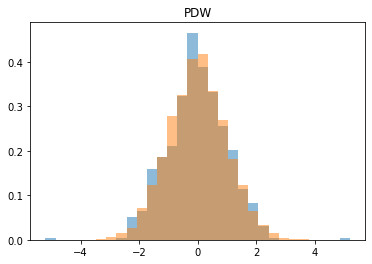

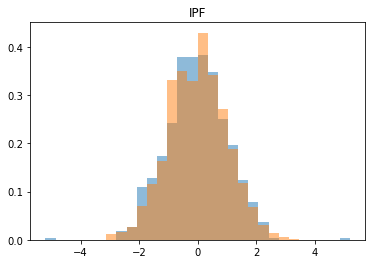

In [73]:
for c in covar.columns:
    plt.figure()
    plt.hist(covar.loc[covar.index.isin(pfc_IDs),c],density=True,alpha=.5,bins=30)
    plt.hist(covar.loc[covar.index.isin(int_IDs),c],density=True,alpha=.5,bins=30)
    plt.title(c)

In [74]:
features.to_hdf("%s/features.hdf" % training_data,key="features")
covar.to_hdf("%s/covar.hdf" % training_data,key="covar")

# Training

In [75]:
features = pd.read_hdf("%s/features.hdf" % training_data, key="features")
covar = pd.read_hdf("%s/covar.hdf" % training_data, key="covar")
pheno_df = pd.read_hdf("%s/pheno_df.hdf" % training_data, key="pheno_df")

In [76]:
covar.head()

MPV       PLT       PCT       PDW       IPF
INT_116_6580100 -0.294590 -0.645493 -1.055238 -0.027086 -1.031896
INT_116_6580000  0.134816 -0.168810 -0.010532  0.474625 -0.219924
INT_116_2129800 -1.364313 -0.999966 -1.502945 -0.956271 -1.217828
INT_116_4555900  0.634415 -2.220121 -2.478185 -0.437340 -0.476872
INT_116_4555800  1.021700 -0.976268 -0.407728  1.028486  0.150016

In [77]:
X_train = pd.merge(covar,pheno_df,left_index=True,right_index=True,how="inner")
X_train = pd.merge(X_train,features,left_index=True,right_index=True,how="inner")

In [78]:
X_train.shape

(527, 40)

In [79]:
from sklearn.cross_decomposition import PLSRegression
from collections import defaultdict 
from scipy.stats import pearsonr

## Estimate performance

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_s

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_s

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_s

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_s

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_s

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_s

/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

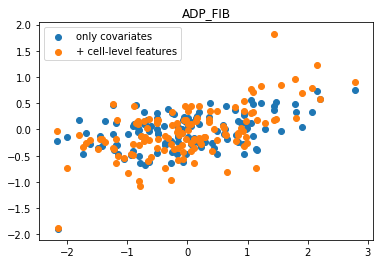

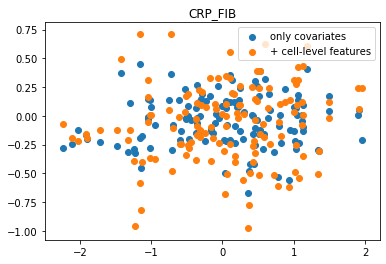

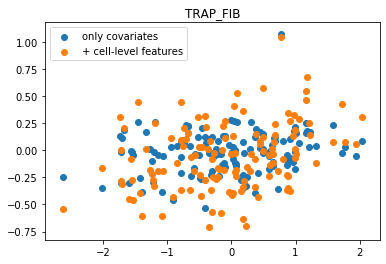

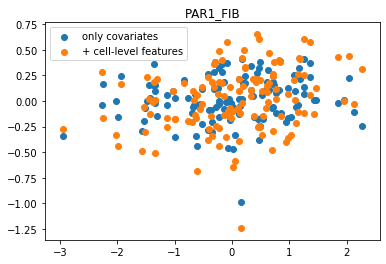

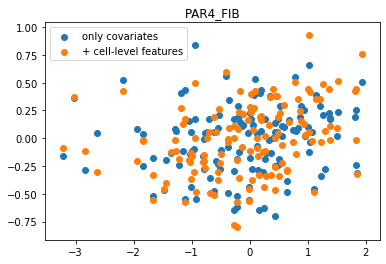

In [80]:
rho_cov = defaultdict(lambda: [])
rho_all = defaultdict(lambda: [])
for c in pheno_cols:
    skf = RepeatedStratifiedKFold(n_splits=4,n_repeats=100)
    y = X_train[c]
    cond = ~y.isnull()
    X = X_train.loc[cond,features.columns]
    C = X_train.loc[cond,covar.columns]
    y = y.loc[cond]
    
    y_split = pd.cut(y,3,labels=False)
    
    for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(y_split)), y_split)):
        #print(len(train_index),len(test_index))
        pls = LinearRegression()
        pls.fit(C.iloc[train_index],y.iloc[train_index])
        y_cov = np.reshape(pls.predict(C),(-1,1))
        
        residuals = y-y_cov[:,0]
        pls_res = PLSRegression(n_components=2)
        pls_res.fit(X.iloc[train_index],residuals.iloc[train_index])
        y_pred = y_cov + pls_res.predict(X)
        if i == 0:
            plt.figure()
            plt.scatter(y.iloc[test_index],y_cov[test_index,0],label="only covariates")
            plt.scatter(y.iloc[test_index],y_pred[test_index,0],label="+ cell-level features")
            plt.legend()
            plt.title(c)
        
        pearson_all = pearsonr(y.iloc[test_index],y_pred[test_index,0])[0]
        pearson_cov = pearsonr(y.iloc[test_index],y_cov[test_index,0])[0]
        rho_cov[c].append(pearson_cov)
        rho_all[c].append(pearson_all)
        

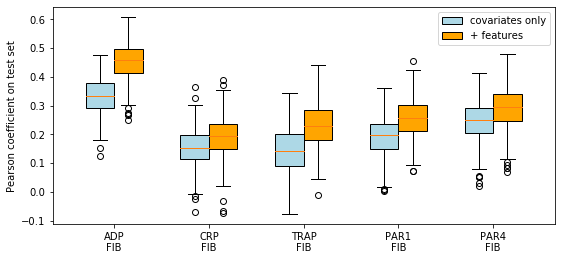

In [81]:
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(111)
bp1 = ax.boxplot([rho_cov[c] for c in rho_cov],
           positions=np.arange(len(rho_cov))-.15,
           widths=0.3,
           patch_artist=True,
           meanprops={"color":"red"},
           boxprops={"facecolor":"lightblue"})
bp2 = ax.boxplot([rho_all[c] for c in rho_cov],
           positions=np.arange(len(rho_cov))+.15,
           widths=0.3,
           patch_artist=True,
           meanprops={"color":"red"},
           boxprops={"facecolor":"orange"});
ax.set_xticks(np.arange(len(rho_cov)))
ax.set_xticklabels(["\n".join(c.split("_")) for c in rho_cov]);
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["covariates only", "+ features"])
ax.set_ylabel("Pearson coefficient on test set");

## Fit

In [82]:
pls = {}
pls_res = {}

predictions = pd.DataFrame(index=X_train.index)

for c in pheno_cols:
    y = X_train[c]
    cond = ~y.isnull()
    X = X_train.loc[cond,features.columns]
    C = X_train.loc[cond,covar.columns]
    y = y.loc[cond]
    
    pls[c] = LinearRegression()
    pls[c].fit(C,y)
    y_cov = np.reshape(pls[c].predict(C),(-1,1))

    residuals = y-y_cov[:,0]
    pls_res[c] = PLSRegression(n_components=2)
    pls_res[c].fit(X,residuals)
    y_pred = y_cov + pls_res[c].predict(X)
    
    predictions[c] = np.nan
    predictions.loc[cond,c] = y_pred[:,0]

## Predict on INTERVAL

In [83]:
X_interval = pd.merge(covar,features,left_index=True,right_index=True,how="inner")

In [84]:
predictions_interval = pd.DataFrame(index=X_interval.index)

for c in pheno_cols:
    X = X_interval[features.columns]
    C = X_interval[covar.columns]
    
    y_cov = np.reshape(pls[c].predict(C),(-1,1))
    y_pred = y_cov + pls_res[c].predict(X)
    
    predictions_interval[c] = y_pred[:,0]

## Check

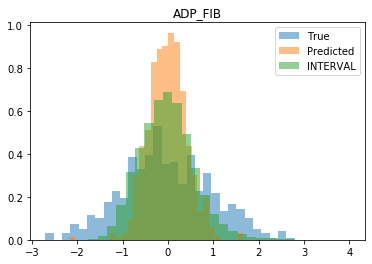

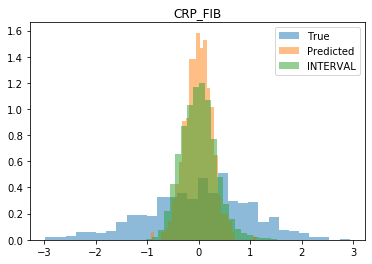

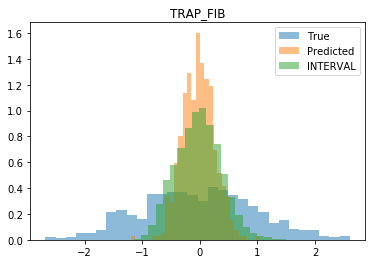

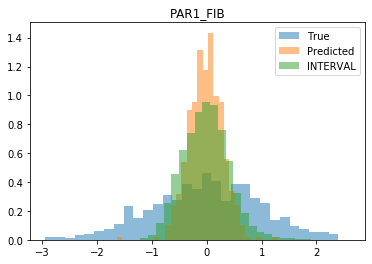

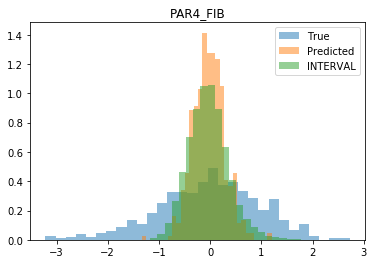

In [85]:
for c in pheno_cols:
    plt.figure()
    plt.hist(pheno_df[c],label="True",alpha=.5,bins=30,density=True)
    plt.hist(predictions[c],label="Predicted",alpha=.5,bins=30,density=True)
    plt.hist(predictions_interval[c],label="INTERVAL",alpha=.5,bins=30,density=True)
    plt.title(c)
    plt.legend();

# Prepare tables for GWAS

In [86]:
from sklearn.preprocessing import RobustScaler

In [87]:
matching = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_phenotypes/INTERVAL_OmicsMap_20200514.csv", sep=",")
matching = matching.loc[~matching["Affymetrix_QC_bl"].isnull()]
matching["Affymetrix_QC_bl"] = matching["Affymetrix_QC_bl"].astype(int).astype(str)
meta = pd.merge(matching,int_phen,left_on="identifier", right_on="valid_id")
meta["IID"] = meta["Affymetrix_QC_bl"]
meta["FID"] = meta["Affymetrix_QC_bl"]

meta["cohort"] = meta.interval
meta.loc[~meta.EpiCovId_bl.isnull() & (meta.sexPulse == 1),"cohort"] = "MBL"
meta.loc[~meta.EpiCovId_bl.isnull() & (meta.sexPulse == 2),"cohort"] = "FBL"

print(meta.cohort.value_counts())

meta["cohort_covar"] = 0
for i, c in enumerate(meta["cohort"].unique().tolist()):
    meta.loc[meta["cohort"] == c,"cohort_covar"] = i
meta["age_covar"] = RobustScaler().fit_transform(meta[["agePulse"]])

pcs = pd.read_csv("%s/principal_components/PC.eigenvec" % export_folder,sep="\t")
pcs["IID"] = pcs["IID"].astype(str)

FBL    11042
MBL    10658
M12     2714
M10     2642
M08     2580
F14     2438
F16     2434
F12     2407
Name: cohort, dtype: int64


In [88]:
match = int_phen.loc[int_phen.ethnicPulse == "Eng/W/Scot/NI/Brit",["SampleNo","valid_id"]]
match["valid_id"] = match["valid_id"].astype(int)

In [92]:
covars = pd.merge(covar,
                 meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"].set_index("SampleNo")[["FID","IID","cohort_covar","sexPulse","age_covar"]],
                left_index=True,right_index=True)
covars = pd.merge(covars,pcs[pcs.columns[1:]],left_on="IID",right_on="IID")
covars = covars[["FID","IID"] + [c for c in covars.columns if c not in ["IID","FID"]]]
covars = covars.dropna(axis=0,how="any")

In [93]:
covars.head()

FID           IID       MPV       PLT       PCT       PDW  \
0  110006795043  110006795043 -0.294590 -0.645493 -1.055238 -0.027086   
1  110004131286  110004131286  0.134816 -0.168810 -0.010532  0.474625   
2  110006795026  110006795026  0.634415 -2.220121 -2.478185 -0.437340   
3  110004131285  110004131285  0.134816  0.380625  0.524631  0.205047   
4  110006494505  110006494505  0.134816  1.119551  1.437908  0.205047   

        IPF  cohort_covar  sexPulse  age_covar       PC1       PC2       PC3  \
0 -1.031896             1         1   0.588235 -0.006143 -0.003414 -0.002550   
1 -0.219924             0         2  -0.932773 -0.002604 -0.000270  0.007260   
2 -0.476872             0         2   0.613445  0.006994  0.005321 -0.006430   
3 -1.123313             1         1   0.189076 -0.000951  0.008243 -0.000835   
4 -0.412638             0         2   0.273109 -0.001484  0.000059 -0.006912   

        PC4       PC5       PC6       PC7       PC8       PC9      PC10  
0 -0.006617  0.007619  0.000518 -0.005138 -0.001251 -0.001450 -0.000475  
1 -0.000367  0.004252  0.004225  0.002824 -0.006574  0.008446  0.005722  
2  0.002057 -0.001391 -0.005765 -0.005126 -0.006106 -0.001899 -0.011991  
3 -0.004595 -0.002367  0.006899  0.004903  0.001809 -0.000368 -0.000548  
4  0.007134  0.001031  0.000255  0.003179  0.004252  0.002089  0.009268

In [94]:
phenotypes = pd.merge(predictions_interval,
                 meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"].set_index("SampleNo")[["FID","IID"]],
                left_index=True,right_index=True)
phenotypes = pd.merge(phenotypes,pcs[pcs.columns[1:]],left_on="IID",right_on="IID")
phenotypes = phenotypes[["FID","IID"] + [c for c in phenotypes.columns if c not in ["IID","FID"] and "PC" not in c]]
phenotypes = phenotypes.dropna(axis=0,how="any")

In [95]:
cov_ids = covars.IID.unique().tolist()
phen_ids = phenotypes.IID.unique().tolist()
covars = covars.loc[covars.IID.isin(phen_ids)].sort_values(by="IID")
phenotypes = phenotypes.loc[phenotypes.IID.isin(cov_ids)].sort_values("IID")
print(covars.shape)
print(phenotypes.shape)

(29646, 20)
(29646, 7)


## Export predictions & covariates

In [96]:
phenotypes.to_csv("%s/phenotypes.csv" % export_folder, index=False,header=True, sep="\t")
covars.to_csv("%s/covars.csv" % export_folder, index=False,header=True, sep="\t")

# Launch GWAS

In [97]:
import subprocess

In [70]:
n_splits = 16
tag = "feb21_adj_machines"
for pheno in pheno_cols:

    command = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/bolt "
    for k in range(1,23):
        command += "--bim=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bim " % k
    # Only one fam file has to be specified
    command += "--fam=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1.fam "
    for k in range(1,23):
        command += "--bed=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bed " % k
    command += "--lmm \
        --LDscoresFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/tables/LDSCORE.1000G_EUR.tab.gz \
        --phenoFile=%s/phenotypes.csv \
        --phenoCol=%s \
        --covarFile=%s/covars.csv \
        --maxMissingPerSnp=0.1 \
        --qCovarCol=PLT \
        --qCovarCol=MPV \
        --qCovarCol=PCT \
        --qCovarCol=PDW \
        --qCovarCol=IPF \
        --qCovarCol=age_covar \
        --covarCol=sexPulse \
        --covarCol=cohort_covar \
        --covarMaxLevels=20 \
        --statsFile=%s/bolt_res_feb_%s \
        --statsFileBgenSnps=%s/bolt_res_bgen_feb_%s \
        --modelSnps=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/indep_snps \
        --bgenFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_{1:22}_interval.bgen \
        --bgenMinMAF=1e-3 \
        --bgenMinINFO=0.4 \
        --lmmForceNonInf \
        --sampleFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample \
        --numThreads=%d" % (export_folder,
                            pheno,
                            export_folder,
                            export_folder,
                            pheno,
                            export_folder,
                            pheno,
                            n_splits)

    f_name = "/home/hv270/interval_slurm_calls/call_%s.sh" % pheno
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (pheno))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=10:00:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,pheno))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % pheno)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p.wait()


Submitting ADP_FIB
Submitting CRP_FIB
Submitting TRAP_FIB
Submitting PAR1_FIB
Submitting PAR4_FIB


In [67]:
cmd = "sbatch %s" % f_name

In [68]:
!{cmd}

sbatch: error: Batch job submission failed: Requested node configuration is not available


# Analyze GWAS

In [249]:
gws = []
for c in tqdm(pheno_cols):
    gw = pd.read_csv("%s/bolt_res_feb_%s" % (export_folder,c),sep="\t")
    gw["pheno"] = c
    gw.P_BOLT_LMM_INF = gw.P_BOLT_LMM_INF.astype(float)
    #gw = gw.loc[gw.SNP != "."]
    gws.append(gw)
gw = pd.concat(gws,axis=0,copy=False)

100%|██████████| 5/5 [00:54<00:00, 10.85s/it]


## QQ-plot

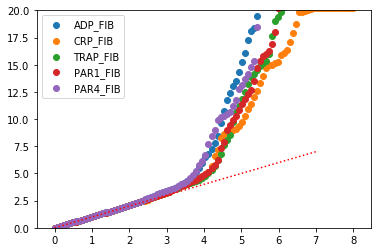

In [250]:
fig = plt.figure()
ax = fig.add_subplot(111)
for c in pheno_cols:
    q_bins = np.logspace(-8,-0.00001,100)
    quantiles = np.array(np.quantile(gw.loc[gw.pheno == c,"P_BOLT_LMM_INF"].astype(float),q_bins),dtype=float)
    ax.scatter(-np.log10(q_bins),-np.log10(quantiles),label=c)
ax.plot([0,7],[0,7],ls=":",c="red")
ax.set_ylim((0,20))
ax.legend()

## Manhattan plot

In [255]:
gw_ = gw.loc[gw.P_BOLT_LMM < 1e-3]
gw_ = gw_.rename(columns={"P_BOLT_LMM":"P"})

In [256]:
gw_["POS"] = gw_["BP"]
for ch in range(1,23):
    gw_.loc[gw_.CHR > ch,"POS"] += gw.loc[gw.CHR == ch,"BP"].max()

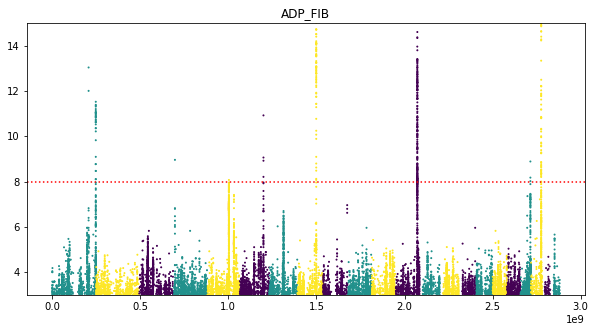

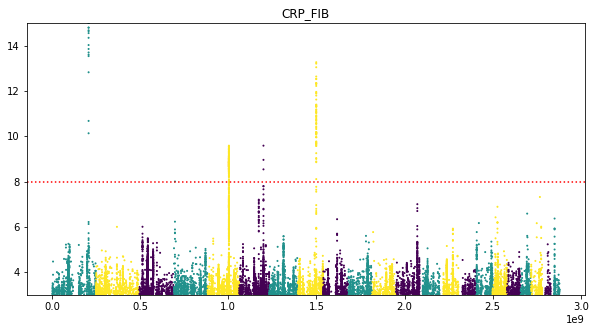

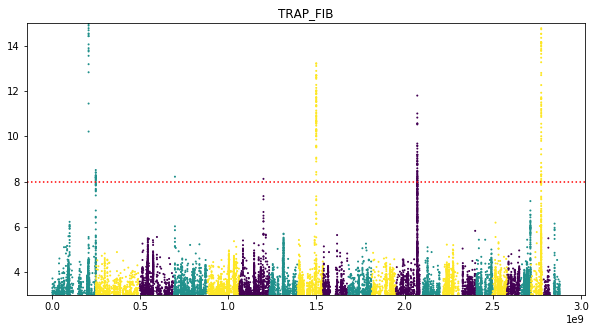

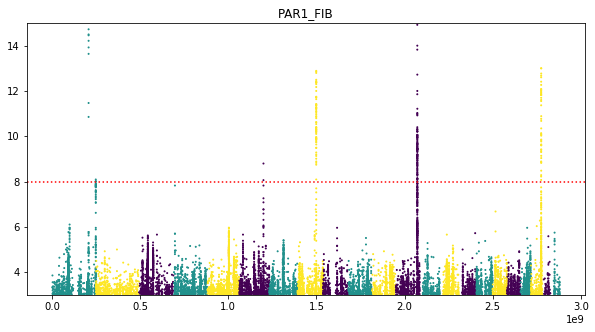

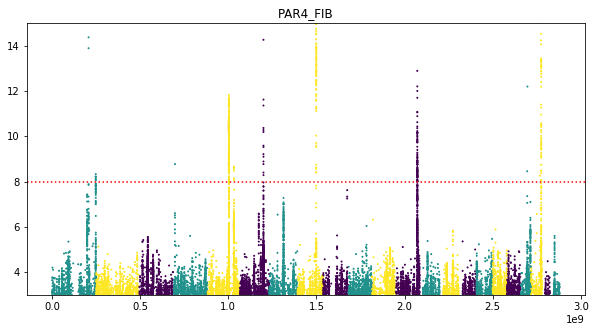

In [257]:
for c in pheno_cols:
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    d = gw_.loc[gw_.pheno == c]
    ax.scatter(d.POS,-np.log10(d.P),c=d.CHR % 3,s=1.)
    ax.set_ylim((3,15))
    ax.set_title(c)
    plt.axhline(8,c="red",ls=":")

## Get list of UKBB SNPs

In [40]:
import subprocess
n_splits = 8
for chrom in [2]:
    command = "/home/hv270/Plink2/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --write-snplist"
    command += " --out %s/UKBB_SNPS_CHR%d" % (export_folder, chrom)
    
    f_name = "/home/hv270/interval_slurm_calls/call_list_snps_chr%s.sh" % chrom
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=2:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % ("UKBB_SNPs",chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % chrom)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 2


In [259]:
UKBB_SNPS = []
for chrom in range(1,23):
    with open("%s/UKBB_SNPS_CHR%d.snplist" % (export_folder, chrom)) as f:
        UKBB_SNPS += [c[:-1] for c in f.readlines()]

print(len(UKBB_SNPS))
print(UKBB_SNPS[:10])
gw_["IN_UKBB"] = gw_.SNP.isin(UKBB_SNPS)
print(gw_["IN_UKBB"].mean())

93095623
['rs367896724', 'rs540431307', 'rs201106462', 'rs548419688', 'rs568405545', 'rs534229142', 'rs537182016', 'rs572818783', 'rs538322974', '1:10616_CCGCCGTTGCAAAGGCGCGCCG_C']
0.916081492226915


## Isolate one SNP per region

In [268]:
from sklearn.cluster import AgglomerativeClustering

In [269]:
good = {}
for c in pheno_cols:
    d = gw_.loc[gw_.pheno == c]
    hits = d.loc[(d.P < 1e-8) & (d.IN_UKBB)].copy()
    hits["region"] = AgglomerativeClustering(n_clusters=None,distance_threshold=1e6,linkage="single")\
                        .fit(np.reshape(hits.POS.values,(-1,1)))\
                        .labels_
    good[c] = hits.sort_values("P",ascending=True).groupby("region").first().sort_values(["CHR","BP"])

In [270]:
good["ADP_FIB"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
region                                                                 
8       rs34101855    1  207281706       0       A      AG  0.880335   
0        rs7536995    1  248012098       0       C       T  0.256876   
4       rs11393160    4    6857838       0       C      CT  0.839881   
6       rs10076288    5  122101327       0       A       G  0.441059   
3       rs12191772    6  137259725       0       G       A  0.811704   
5       rs12680382    8  106524285       0       G       A  0.739371   
2        rs7961894   12  122365583       0       C       T  0.884748   
7        rs1654425   19   55538980       0       T       C  0.166350   
1         rs463312   20   57597970       0       A       C  0.951130   

          F_MISS      BETA        SE  P_BOLT_LMM_INF             P    pheno  \
region                                                                        
8       0.015247  0.052896  0.005055    1.300000e-25  1.500000e-25  ADP_FIB   
0       0.007859  0.026081  0.003760    4.000000e-12  3.000000e-12  ADP_FIB   
4       0.064967 -0.027495  0.004591    2.100000e-09  1.100000e-09  ADP_FIB   
6       0.004216 -0.018791  0.003299    1.200000e-08  8.500000e-09  ADP_FIB   
3       0.001923 -0.028233  0.004190    1.600000e-11  1.200000e-11  ADP_FIB   
5       0.016191  0.031177  0.003752    9.700000e-17  1.800000e-16  ADP_FIB   
2       0.000371  0.067654  0.005168    3.700000e-39  5.800000e-40  ADP_FIB   
7       0.004587 -0.026750  0.004376    9.800000e-10  1.300000e-09  ADP_FIB   
1       0.001585 -0.159724  0.007642    5.300000e-97  3.100000e-97  ADP_FIB   

               POS  IN_UKBB  
region                       
8        207281706     True  
0        248012098     True  
4        697246618     True  
6       1003533984     True  
3       1199528980     True  
5       1498975513     True  
2       2072738067     True  
7       2714173637     True  
1       2775351551     True

In [271]:
good["CRP_FIB"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
region                                                                 
3       rs34101855    1  207281706       0       A      AG  0.880335   
0       rs10076288    5  122101327       0       A       G  0.441059   
1       rs12191772    6  137259725       0       G       A  0.811704   
2       rs12680382    8  106524285       0       G       A  0.739371   

          F_MISS      BETA        SE  P_BOLT_LMM_INF             P    pheno  \
region                                                                        
3       0.015247  0.024570  0.002616    5.900000e-21  5.300000e-21  CRP_FIB   
0       0.004216 -0.010740  0.001707    3.100000e-10  2.600000e-10  CRP_FIB   
1       0.001923 -0.013651  0.002168    3.000000e-10  2.600000e-10  CRP_FIB   
2       0.016191  0.014517  0.001942    7.600000e-14  9.000000e-14  CRP_FIB   

               POS  IN_UKBB  
region                       
3        207281706     True  
0       1003533984     True  
1       1199528980     True  
2       1498975513     True

In [272]:
good["PAR4_FIB"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
region                                                                  
8        rs34101855    1  207281706       0       A      AG  0.880335   
0         rs7536995    1  248012098       0       C       T  0.256876   
9        rs11393160    4    6857838       0       C      CT  0.839881   
4        rs10076288    5  122101327       0       A       G  0.441059   
3        rs11953411    5  150798334       0       G       A  0.397797   
7        rs12191772    6  137259725       0       G       A  0.811704   
5        rs12680382    8  106524285       0       G       A  0.739371   
2         rs7961894   12  122365583       0       C       T  0.884748   
11      rs149366150   19   37343674       0       A       G  0.969968   
6        rs35496032   19   38817628       0       G       A  0.986400   
10      rs560568175   20   50327067       0       C       G  0.992533   
1          rs463312   20   57597970       0       A       C  0.951130   

          F_MISS      BETA        SE  P_BOLT_LMM_INF             P     pheno  \
region                                                                         
8       0.015247  0.034473  0.003074    3.500000e-29  3.800000e-29  PAR4_FIB   
0       0.007859  0.013382  0.002286    4.800000e-09  4.700000e-09  PAR4_FIB   
9       0.064967 -0.016586  0.002792    2.800000e-09  1.700000e-09  PAR4_FIB   
4       0.004216 -0.014053  0.002006    2.400000e-12  1.500000e-12  PAR4_FIB   
3       0.049147  0.012422  0.002084    2.500000e-09  2.200000e-09  PAR4_FIB   
7       0.001923 -0.019758  0.002548    8.800000e-15  5.500000e-15  PAR4_FIB   
5       0.016191  0.018937  0.002282    1.000000e-16  1.900000e-16  PAR4_FIB   
2       0.000371  0.032929  0.003143    1.100000e-25  4.600000e-26  PAR4_FIB   
11      0.059333 -0.034901  0.005955    4.600000e-09  3.500000e-09  PAR4_FIB   
6       0.000439 -0.061643  0.008565    6.100000e-13  6.400000e-13  PAR4_FIB   
10      0.031033 -0.068421  0.011729    5.400000e-09  5.500000e-09  PAR4_FIB   
1       0.001585 -0.075866  0.004647    6.600000e-60  7.600000e-60  PAR4_FIB   

               POS  IN_UKBB  
region                       
8        207281706     True  
0        248012098     True  
9        697246618     True  
4       1003533984     True  
3       1032230991     True  
7       1199528980     True  
5       1498975513     True  
2       2072738067     True  
11      2695978331     True  
6       2697452285     True  
10      2768080648     True  
1       2775351551     True

In [265]:
# PEAR1
gw.loc[gw.SNP == "rs12566888"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
392801  rs12566888    1  156869047       0       G       T  0.910867   
392801  rs12566888    1  156869047       0       G       T  0.910867   
392801  rs12566888    1  156869047       0       G       T  0.910867   
392801  rs12566888    1  156869047       0       G       T  0.910867   
392801  rs12566888    1  156869047       0       G       T  0.910867   

          F_MISS      BETA        SE  P_BOLT_LMM_INF  P_BOLT_LMM     pheno  
392801  0.003576  0.015300  0.005742          0.0077      0.0064   ADP_FIB  
392801  0.003576  0.001660  0.002971          0.5800      0.5600   CRP_FIB  
392801  0.003576  0.007609  0.004010          0.0580      0.0550  TRAP_FIB  
392801  0.003576  0.004875  0.003779          0.2000      0.1900  PAR1_FIB  
392801  0.003576  0.007793  0.003491          0.0260      0.0220  PAR4_FIB

In [266]:
# ADRA2A (epinephrine)
gw.loc[gw.SNP == "rs4311994"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
5795507  rs4311994   10  112903090       0       C       T  0.843312   
5795507  rs4311994   10  112903090       0       C       T  0.843312   
5795507  rs4311994   10  112903090       0       C       T  0.843312   
5795507  rs4311994   10  112903090       0       C       T  0.843312   
5795507  rs4311994   10  112903090       0       C       T  0.843312   

           F_MISS      BETA        SE  P_BOLT_LMM_INF  P_BOLT_LMM     pheno  
5795507  0.018552 -0.004398  0.004543            0.33        0.34   ADP_FIB  
5795507  0.018552 -0.001299  0.002351            0.58        0.57   CRP_FIB  
5795507  0.018552 -0.002468  0.003173            0.44        0.43  TRAP_FIB  
5795507  0.018552 -0.002384  0.002990            0.43        0.42  PAR1_FIB  
5795507  0.018552 -0.002256  0.002763            0.41        0.41  PAR4_FIB

In [267]:
# GP6
gw.loc[gw.SNP == "rs1671152"]

SNP  CHR        BP  GENPOS ALLELE1 ALLELE0    A1FREQ    F_MISS  \
8620491  rs1671152   19  55526345       0       T       G  0.157089  0.026209   
8620491  rs1671152   19  55526345       0       T       G  0.157089  0.026209   
8620491  rs1671152   19  55526345       0       T       G  0.157089  0.026209   
8620491  rs1671152   19  55526345       0       T       G  0.157089  0.026209   
8620491  rs1671152   19  55526345       0       T       G  0.157089  0.026209   

             BETA        SE  P_BOLT_LMM_INF    P_BOLT_LMM     pheno  
8620491 -0.024545  0.004536    6.300000e-08  8.000000e-08   ADP_FIB  
8620491 -0.006174  0.002347    8.500000e-03  8.600000e-03   CRP_FIB  
8620491 -0.015454  0.003168    1.100000e-06  1.200000e-06  TRAP_FIB  
8620491 -0.012172  0.002985    4.600000e-05  5.100000e-05  PAR1_FIB  
8620491 -0.012969  0.002758    2.600000e-06  2.900000e-06  PAR4_FIB

## Box plots

In [23]:
s_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample"

In [24]:
bgens = {}
for CH in tqdm(range(1,23)):
    f_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_%d_interval.bgen" % CH
    bgens[CH] = BgenFile(f_path, sample_path=s_path, delay_parsing=True)

100%|██████████| 22/22 [00:00<00:00, 175.14it/s]


In [25]:
interesting_IDs = []
for c in pheno_cols:
    interesting_IDs += good[c].SNP.tolist()

In [26]:
dosages = {}
dom = {}
alleles = {}
for CH in [19]:
    for v in tqdm(bgens[CH]):
        if v.rsid in interesting_IDs:
            dosages[v.rsid] = v.minor_allele_dosage
            dom[v.rsid] = np.argmax(v.probabilities,axis=1)
            alleles[v.rsid] = v.alleles

100%|██████████| 1965269/1965269 [00:33<00:00, 58648.28it/s]


In [27]:
samples = bgens[1].samples
phenotypes = pd.read_csv("%s/phenotypes.csv" % export_folder,sep="\t")
covariates = pd.read_csv("%s/covars.csv" % export_folder,sep="\t")

del phenotypes["FID"]
del covariates["FID"]
#for c in covariates.columns:
#    if "PC" in c and c != "PCT":
#        del covariates[c]
phenotypes.set_index("IID",inplace=True)
covariates.set_index("IID",inplace=True)
covariates = pd.concat((covariates,pd.get_dummies(covariates["cohort_covar"])),axis=1)
del covariates["cohort_covar"]
X = pd.merge(phenotypes,covariates,how="inner",left_index=True,right_index=True)

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
lm = LinearRegression().fit(X[covariates.columns],X[phenotypes.columns])
X[phenotypes.columns] = X[phenotypes.columns] - lm.predict(X[covariates.columns])

In [30]:
X[covariates.columns]

MPV       PLT       PCT       PDW       IPF  sexPulse  \
IID                                                                        
110000305926 -0.745810  0.527510  0.172881 -0.839907 -0.855712         2   
110000305952 -0.745810  0.257596 -0.407728 -0.437340 -1.031896         1   
110000315493  0.535019 -0.623413 -0.204023  0.474625 -0.619155         1   
110000315494  0.734597  0.580133  0.999966  0.252415  0.611881         2   
110000315495  0.930445 -0.931218 -0.617333  0.875407  1.674473         1   
...                ...       ...       ...       ...       ...       ...   
119999995920  0.438444 -0.909767 -0.833502  0.390349  1.058745         1   
119999995922 -0.861513  0.673546  0.350597 -0.719572 -0.855712         2   
119999995934  0.438444  0.810998  1.295122  0.513727  0.102491         1   
119999995944  1.204254 -0.346867  0.350597  1.206328  1.300945         1   
119999995958 -0.079827  0.310340  0.172881 -0.027086  0.195326         2   

              age_covar       PC1       PC2       PC3  ...       PC9  \
IID                                                    ...             
110000305926   0.163866  0.001051 -0.005030  0.000366  ... -0.000403   
110000305952   0.214286 -0.000064 -0.000603  0.000856  ... -0.000623   
110000315493   0.478992  0.001009  0.004312 -0.009543  ...  0.002414   
110000315494   0.495798  0.006815  0.000915  0.006795  ...  0.007461   
110000315495  -0.306723  0.006833  0.003003  0.002493  ...  0.001188   
...                 ...       ...       ...       ...  ...       ...   
119999995920   1.000000  0.002195 -0.000598 -0.002473  ...  0.003552   
119999995922   0.592437  0.005786  0.007619  0.000849  ... -0.002771   
119999995934  -0.924370 -0.007510 -0.000378 -0.002623  ...  0.004138   
119999995944  -1.004202  0.000856 -0.003291 -0.005255  ...  0.008342   
119999995958   0.886555 -0.000309  0.003338  0.006873  ... -0.004282   

                  PC10  0  1  2  3  4  5  6  7  
IID                                             
110000305926 -0.004247  1  0  0  0  0  0  0  0  
110000305952  0.001776  0  1  0  0  0  0  0  0  
110000315493  0.001101  0  1  0  0  0  0  0  0  
110000315494  0.002496  1  0  0  0  0  0  0  0  
110000315495  0.000879  0  1  0  0  0  0  0  0  
...                ... .. .. .. .. .. .. .. ..  
119999995920 -0.004657  0  1  0  0  0  0  0  0  
119999995922 -0.001967  1  0  0  0  0  0  0  0  
119999995934  0.002752  0  1  0  0  0  0  0  0  
119999995944 -0.005231  0  1  0  0  0  0  0  0  
119999995958  0.004645  1  0  0  0  0  0  0  0  

[29646 rows x 25 columns]

In [31]:
from scipy.stats import pearsonr

In [32]:
for c in phenotypes.columns:
    print(c, pearsonr(X[c],phenotypes[c]))

ADP_FIB (0.6585964071849925, 0.0)
CRP_FIB (0.602565524480887, 0.0)
TRAP_FIB (0.705703478901672, 0.0)
PAR1_FIB (0.6196402219565443, 0.0)
PAR4_FIB (0.607812722375674, 0.0)


In [33]:
len(samples)

43059

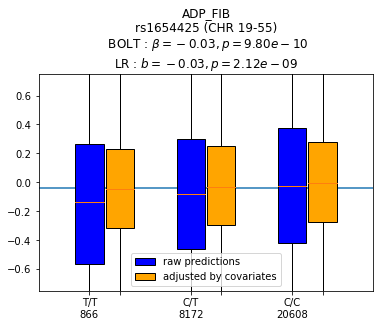

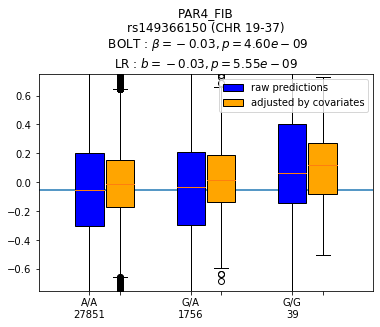

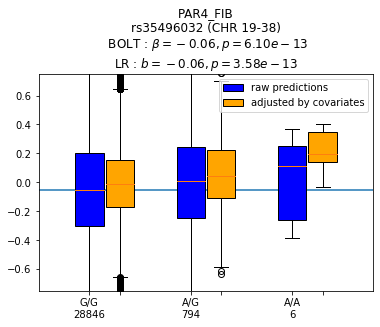

In [40]:
for c in pheno_cols:
    for i, row in good[c].iterrows():
        if row["CHR"] not in [19]: continue
        fig = plt.figure()
        ax = fig.add_subplot(111)
        IDs = {}
        allele_counts = sorted(np.unique(dom[row["SNP"]]))
        allele = alleles[row["SNP"]]
        allele_ref = ["%s/%s" % (allele[0],allele[0]), "%s/%s" % (allele[1],allele[0]), "%s/%s" % (allele[1],allele[1])]
        for k in allele_counts:
            IDs[k] = [int(samples[i]) for i in np.where(dom[row["SNP"]] == k)[0]]
        bp1 = ax.boxplot([phenotypes.loc[phenotypes.index.isin(IDs[k]),c] for k in allele_counts],
                  positions=np.arange(len(IDs))-.15,
                           widths=0.28,
                           patch_artist=True,
                           meanprops={"color":"red"},
                           boxprops={"facecolor":"blue"})
        bp2 = ax.boxplot([X.loc[X.index.isin(IDs[k]),c] for k in allele_counts],
                  positions=np.arange(len(IDs))+.15,
                           widths=0.28,
                           patch_artist=True,
                           meanprops={"color":"red"},
                           boxprops={"facecolor":"orange"})
        
        M = pd.DataFrame(data={"IID":[int(s) for s in samples],"count":dom[row["SNP"]]})
        M = pd.merge(M,X, left_on="IID",right_on="IID",how="right")
        
        _, p = pearsonr(M["count"],M[c])
        b = -LinearRegression().fit(np.reshape(M["count"].values,(-1,1)),M[c]).coef_[0]
        
        ax.set_xticklabels([allele_ref[k] + "\n" + str(phenotypes.index.isin(IDs[k]).sum()) for k in allele_counts])
        ax.set_title("%s\n%s (CHR %d-%d)\n BOLT : $\\beta = %.2f, p=%.2e$\nLR : $b=%.2f, p=%.2e$" % \
                     (c, row["SNP"], int(row["CHR"]),int(row["BP"]) // int(1e6),row["BETA"], row["P"], b, p))
        ax.set_ylim((-.75,.75))
        ax.axhline(phenotypes[c].median())
        ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["raw predictions", "adjusted by covariates"])

In [41]:
good["PAR4_FIB"]

SNP  CHR         BP  GENPOS ALLELE1 ALLELE0    A1FREQ  \
region                                                                  
8        rs34101855    1  207281706       0       A      AG  0.880335   
6         rs7536995    1  248012098       0       C       T  0.256876   
9        rs11393160    4    6857838       0       C      CT  0.839881   
4        rs10076288    5  122101327       0       A       G  0.441059   
3        rs12655145    5  150835349       0       A       G  0.387112   
7        rs12191772    6  137259725       0       G       A  0.811704   
2        rs12680382    8  106524285       0       G       A  0.739371   
0         rs7961894   12  122365583       0       C       T  0.884748   
11      rs149366150   19   37343674       0       A       G  0.969968   
5        rs35496032   19   38817628       0       G       A  0.986400   
10      rs560568175   20   50327067       0       C       G  0.992533   
1          rs463312   20   57597970       0       A       C  0.951130   

          F_MISS      BETA        SE             P     pheno         POS  \
region                                                                     
8       0.015247  0.034473  0.003074  3.500000e-29  PAR4_FIB   207281706   
6       0.007859  0.013382  0.002286  4.800000e-09  PAR4_FIB   248012098   
9       0.064967 -0.016586  0.002792  2.800000e-09  PAR4_FIB   697246618   
4       0.004216 -0.014053  0.002006  2.400000e-12  PAR4_FIB  1003533984   
3       0.048911  0.012479  0.002093  2.500000e-09  PAR4_FIB  1032268006   
7       0.001923 -0.019758  0.002548  8.800000e-15  PAR4_FIB  1199528980   
2       0.016191  0.018937  0.002282  1.000000e-16  PAR4_FIB  1498975513   
0       0.000371  0.032929  0.003143  1.100000e-25  PAR4_FIB  2072738067   
11      0.059333 -0.034901  0.005955  4.600000e-09  PAR4_FIB  2695978331   
5       0.000439 -0.061643  0.008565  6.100000e-13  PAR4_FIB  2697452285   
10      0.031033 -0.068421  0.011729  5.400000e-09  PAR4_FIB  2768080648   
1       0.001585 -0.075866  0.004647  6.600000e-60  PAR4_FIB  2775351551   

        IN_UKBB  
region           
8          True  
6          True  
9          True  
4          True  
3          True  
7          True  
2          True  
0          True  
11         True  
5          True  
10         True  
1          True

# Genetic scores

In [273]:
# Extract rsIDs present in UKBB files, as well as ref/alt alleles
# Compute score based on best alleles

## Compute

In [274]:
for pheno in pheno_cols:
    # Checked only on one sample, that REF was the column to use
    # It corresponds to the same side (between ref and alt) 
    # as the one used to compute the score of our phenotypes based on interval GWAS
    betas_path = "%s/Genetic_score_Sysmex_traits/%s.csv" % (export_folder,pheno)
    good[pheno][["SNP","ALLELE1","BETA"]]\
        .to_csv(betas_path,
                sep="\t",index=False,header=False)
    
    causal_snps = good[pheno].SNP.tolist()
    causal_snps_path = "%s/Genetic_score_Sysmex_traits/causal_snps_%s" % (export_folder,pheno)
    with open(causal_snps_path,"w") as snp_file:
        for snp in causal_snps:
            snp_file.write("%s\n" % snp)
    
    n_splits = 8

    for chrom in good[pheno].CHR.unique().tolist():
        command = "/home/hv270/Plink2/plink2"
        command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
        command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
        command += " --extract %s" % causal_snps_path
        #command += " --keep %s" % EUR_path
        command += " --score %s" % betas_path
        command += " --out %s/Genetic_score_Sysmex_traits/%s_good_score_chr%s" % (export_folder,pheno,chrom)
        command += " --threads %d" % n_splits

        f_name = "/home/hv270/interval_slurm_calls/call_gs_chr%s.sh" % chrom
        f = open(f_name,"w+")
        f.write("#!/bin/sh\n")

        f.write("#SBATCH -J chr%s\n" % (chrom))
        f.write("#SBATCH -A ASTLE-SL2-CPU\n")
        f.write("#SBATCH -N 1\n")
        f.write("#SBATCH -n %d\n" % n_splits)
        f.write("#SBATCH --time=3:30:00\n")
        f.write("#SBATCH -p skylake\n")
        f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("GS",pheno,chrom))
        f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

        f.write(". /etc/profile.d/modules.sh\n")
        f.write("module purge\n")
        f.write("module load rhel7/default-peta4\n")
        f.write(command)
        f.close()

        print("Submitting %s %s" % (pheno,chrom))
        p = subprocess.Popen("sbatch %s" % f_name,shell=True)
        p.wait()

Submitting ADP_FIB 1
Submitting ADP_FIB 4
Submitting ADP_FIB 5
Submitting ADP_FIB 6
Submitting ADP_FIB 8
Submitting ADP_FIB 12
Submitting ADP_FIB 19
Submitting ADP_FIB 20
Submitting CRP_FIB 1
Submitting CRP_FIB 5
Submitting CRP_FIB 6
Submitting CRP_FIB 8
Submitting TRAP_FIB 1
Submitting TRAP_FIB 4
Submitting TRAP_FIB 6
Submitting TRAP_FIB 8
Submitting TRAP_FIB 12
Submitting TRAP_FIB 20
Submitting PAR1_FIB 1
Submitting PAR1_FIB 6
Submitting PAR1_FIB 8
Submitting PAR1_FIB 12
Submitting PAR1_FIB 20
Submitting PAR4_FIB 1
Submitting PAR4_FIB 4
Submitting PAR4_FIB 5
Submitting PAR4_FIB 6
Submitting PAR4_FIB 8
Submitting PAR4_FIB 12
Submitting PAR4_FIB 19
Submitting PAR4_FIB 20


## Read scores

In [166]:
scores = {}
for pheno in pheno_cols:
    f = glob.glob("%s/Genetic_score_Sysmex_traits/%s_good_score_chr*.sscore" % (export_folder,pheno))
    print([s.split("chr")[-1][:-7] for s in f])
    print(pheno,len(f))
    s = [pd.read_csv(f[i],sep="\t").set_index("IID")[["SCORE1_AVG"]].rename(columns={"SCORE1_AVG":i}) for i in range(len(f))]
    scores[pheno] = pd.concat(s,axis=1,join="outer").sum(axis=1)
scores = pd.concat(scores,axis=1)

['4', '19', '20', '1']
ADP_FIB 4
['6', '1', '8']
CRP_FIB 3
['1', '12', '4', '6']
TRAP_FIB 4
['8', '20', '6', '12', '1']
PAR1_FIB 5
['4', '20', '1', '6', '8', '19']
PAR4_FIB 6


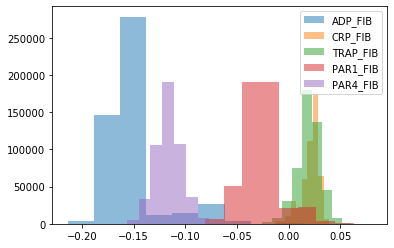

In [167]:
for s in scores:
    plt.hist(scores[s],label=s,alpha=.5)
plt.legend()

## Read Sysmex traits scores

In [202]:
sys_phenos = ["PLT#","MPV","PCT","PDW"]
score_dfs = []
for pheno in sys_phenos:
    dfs = []
    chrom_files = glob.glob("%s/Genetic_score_Sysmex_traits/%s_causal_score_chr*.sscore" % (export_folder,pheno))
    for score_file in chrom_files:
        df = pd.read_csv(score_file,sep="\t")
        df["score"] = df["SCORE1_AVG"]
        dfs.append(df[["IID","score"]].rename(columns={"score":"score_%d" % chrom}))
    df = dfs[0]
    for d in dfs[1:]:
        df = pd.merge(df,d,left_on="IID",right_on="IID",how="inner")
    df = df.set_index("IID")
    score_dfs.append(pd.DataFrame(df.sum(axis=1)).rename(columns={0:pheno}))
scores_sys = pd.concat(score_dfs,axis=1)

## Read UKBB phenotypes

In [99]:
STROKE_FIELD = "42006-0.0"
BIRTH_FIELD = "34-0.0"
SEX_FIELD = "31-0.0" # 0 female, 1 male
MI_FIELD = "42000-0.0" 
AGE_DVT = "4012-0.0" # Deep venous thrombosis, blot clot in the leg
PE_FIELD  = "4022-0.0" # pulmonary embolism, age
KINSHIP = '22021-0.0'
DEATH_FIELD = '40007-0.0'
BP_FIELD = '2966-0.0' # Age high blood pressure diagnosed
PLT = '30080-0.0'
PCT = '30090-0.0'
MPV = '30100-0.0'
PDW = '30110-0.0'

TOBACCO_FIELD = "22506-0.0"
ID_FIELD = "eid"

ukbb_path = "/home/hv270/rds/rds-who1000-cbrc/data/UKB_13745/flat_data/ukb44092.csv"

for chunk in pd.read_csv(ukbb_path,sep=",",chunksize=int(1e2),low_memory=False):
    ukbb_ = chunk
    break
ICD10_cols = [c for c in ukbb_ if "41270" in c]
death_cols = [c for c in ukbb_ if "40002" in c]

cols = [ID_FIELD,BIRTH_FIELD,SEX_FIELD,STROKE_FIELD,
        MI_FIELD, PE_FIELD, AGE_DVT,
        DEATH_FIELD,
        BP_FIELD,
        MPV, PCT, PDW, PLT,
        TOBACCO_FIELD, KINSHIP]
cols = cols + ICD10_cols #+ death_cols

ukbb_ = pd.read_csv(ukbb_path,sep=",",usecols=cols, low_memory=True);

In [100]:
ukbb = ukbb_.rename(columns={STROKE_FIELD:"STROKE_DATE",
                            MI_FIELD:"MI_DATE",
                            ID_FIELD:"ID",
                            SEX_FIELD:"SEX",
                            BIRTH_FIELD:"BIRTH",
                            AGE_DVT:"VT_AGE",
                            DEATH_FIELD:"DEATH_AGE",
                            BP_FIELD:"HIGH_BP_AGE",
                            PE_FIELD:"PE_AGE",
                            KINSHIP:"KINSHIP",
                            PLT:"PLT",MPV:"MPV",PCT:"PCT",PDW:"PDW",
                            TOBACCO_FIELD:"TOBACCO"})
ukbb["BIRTH"] = pd.to_datetime(ukbb.loc[~ukbb.BIRTH.isnull(), "BIRTH"].astype(int).astype(str),format="%Y")
ukbb["MI_AGE"] = pd.to_datetime(ukbb["MI_DATE"]) - ukbb["BIRTH"]
ukbb["STROKE_AGE"] = pd.to_datetime(ukbb["STROKE_DATE"]) - ukbb["BIRTH"]

In [101]:
ukbb["coag_deffect"] = sum([ukbb[c].str.contains("D68").fillna(False)*1 for c in ICD10_cols]) > 0
ukbb["haemo"] = sum([ukbb[c].str.contains("D69").fillna(False)*1 for c in ICD10_cols]) > 0
ukbb["arteriosclerosis"] = sum([ukbb[c].str.contains("I25").fillna(False)*1 for c in ICD10_cols]) > 0

th_codes = ["I74","I80","I81","I82"]
ukbb["thrombosis"] = sum([sum([ukbb[c].str.contains(code).fillna(False)*1 for c in ICD10_cols]) for code in th_codes]) > 0

ukbb["haemorroids"] = sum([ukbb[c].str.contains("K64").fillna(False)*1 for c in ICD10_cols]) > 0

from datetime import datetime
ukbb.loc[~ukbb.MI_AGE.isnull(),"MI_AGE"] = ukbb.loc[~ukbb.MI_AGE.isnull(),"MI_AGE"].astype('timedelta64[Y]').astype(int)
ukbb.loc[~ukbb.STROKE_AGE.isnull(),"STROKE_AGE"] = ukbb.loc[~ukbb.STROKE_AGE.isnull(),"STROKE_AGE"].astype('timedelta64[Y]').astype(int)
# Removing those whose date isn't available
ukbb.loc[ukbb.MI_AGE < 0,"MI_AGE"] = np.nan
ukbb.loc[ukbb.STROKE_AGE < 0,"STROKE_AGE"] = np.nan
print("Remove %d because of missing age " % ukbb.BIRTH.isnull().sum())
ukbb = ukbb.loc[~ukbb.BIRTH.isnull()]
ukbb["AGE"] = (datetime.now() - ukbb["BIRTH"]).astype('timedelta64[Y]').astype(int)

Remove 1 because of missing age 


In [102]:
ukbb["has_VT"] = (~ukbb.VT_AGE.isnull())
ukbb["has_PE"] = (~ukbb.PE_AGE.isnull())
ukbb["has_stroke"] = ~ukbb.STROKE_AGE.isnull()
ukbb["has_mi"] = ~ukbb.MI_AGE.isnull()
ukbb["has_hbp"] = ~ukbb.HIGH_BP_AGE.isnull()

In [104]:
scores["ADP_FIB"]

IID
3988147   -0.153727
5152243   -0.160771
2770265   -0.153878
3790399   -0.160286
4681935   -0.187370
             ...   
4494916   -0.173995
4272180   -0.094133
2654475   -0.147023
4943537   -0.134037
2379838   -0.187370
Length: 487409, dtype: float64

In [203]:
X = pd.merge(ukbb,scores,left_on="ID",right_index=True,copy=False)

In [204]:
rel = pd.read_csv("/home/hv270/rds/rds-wja24-uk-biobank-gen/rel/ukb13745_rel_s488339.dat",sep=" ")
people_to_remove = rel.loc[rel.Kinship < 0.0612].ID2.unique().tolist()
print(X.shape)
X = X.loc[~X.ID.isin(people_to_remove)]
print(X.shape)
european_individuals = pd.read_csv("/rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/blood_trait_gwas_2020_contributing_ids.tsv",header=None)
european_individuals = european_individuals.rename(columns={0:"FID"})
EUR_IDs = european_individuals.FID.tolist()
X = X.loc[X.ID.isin(EUR_IDs)]
print(X.shape)

(487283, 246)
(458695, 246)
(384059, 246)


In [205]:
X.head()

ID  SEX      BIRTH  HIGH_BP_AGE  VT_AGE  PE_AGE  KINSHIP  TOBACCO  \
1  1000011  1.0 1943-01-01          NaN     NaN     NaN      1.0      NaN   
2  1000026  1.0 1960-01-01          NaN     NaN     NaN      1.0      NaN   
3  1000032  0.0 1950-01-01          NaN     NaN     NaN      1.0    114.0   
4  1000044  1.0 1949-01-01         58.0     NaN     NaN      1.0      NaN   
5  1000058  1.0 1944-01-01          NaN     NaN     NaN      0.0      NaN   

     PLT    PCT  ...  has_VT  has_PE  has_stroke has_mi has_hbp   ADP_FIB  \
1  250.0  0.207  ...   False   False       False  False   False -0.181000   
2  138.2  0.153  ...   False   False       False  False   False -0.174146   
3  174.3  0.161  ...   False   False       False  False   False -0.154251   
4  164.9  0.148  ...   False   False       False   True    True -0.140503   
5  274.8  0.235  ...   False   False       False  False   False -0.160398   

    CRP_FIB  TRAP_FIB  PAR1_FIB  PAR4_FIB  
1  0.025436  0.021627 -0.021365 -0.117241  
2  0.032262  0.026177 -0.016630 -0.110707  
3  0.017744  0.030060 -0.031476 -0.126298  
4  0.032262  0.039319 -0.013075 -0.099068  
5  0.025003  0.035437 -0.025831 -0.111882  

[5 rows x 246 columns]

In [208]:
scores_sys = scores_sys.rename(columns={"PLT#":"PLT"})
scores_sys = scores_sys.add_suffix("_score")
X = pd.merge(X,scores_sys,left_on="ID",right_index=True,how="left")

In [209]:
X = X.dropna(subset=scores_sys.columns,how="any")

In [210]:
scores_sys.columns

Index(['PLT_score', 'MPV_score', 'PCT_score', 'PDW_score'], dtype='object')

In [211]:
for p in pheno_cols:
    lm = LinearRegression().fit(X[scores_sys.columns],X[p])
    X[p+"_adj"] = X[p] - lm.predict(X[scores_sys.columns])

In [212]:
from scipy.stats import binom_test, wilcoxon, mannwhitneyu

for c in["has_mi","has_hbp","has_VT","has_stroke"]:
    for pheno in pheno_cols:
        cond1 = X[pheno] < X[pheno].quantile(0.1)
        cond2 = X[pheno] > X[pheno].quantile(0.9)
        p_low = binom_test(X.loc[cond1,c].sum(),n=cond1.sum(),p=X.loc[~cond1,c].mean())
        p_up = binom_test(X.loc[cond2,c].sum(),n=cond2.sum(),p=X.loc[~cond2,c].mean())
        p_uplow = binom_test(X.loc[cond1,c].sum(),n=cond1.sum(),p=X.loc[cond2,c].mean())
        if p_low < 1e-2:
            print(c, pheno, "low", p_low)
        if p_up < 1e-2:
            print(c, pheno, "up",p_up)
        if p_uplow < 1e-2:
            print(c, pheno, "uplow",p_uplow)

has_mi CRP_FIB uplow 0.0033527152368995113
has_mi TRAP_FIB up 0.002807038785594216
has_mi TRAP_FIB uplow 0.000123704717618347
has_hbp PAR4_FIB low 0.005324211701603165
has_hbp PAR4_FIB uplow 7.0031882661904085e-06
has_VT PAR4_FIB uplow 0.001908230934214611
has_stroke CRP_FIB uplow 0.0005053391515792984
has_stroke PAR4_FIB low 0.0026440162690641693


has_mi TRAP_FIB_adj up 0.006042436708183113
has_mi TRAP_FIB_adj uplow 7.6755197107115e-06
has_mi TRAP_FIB_adj lowup 4.747908699944701e-06
has_mi TRAP_FIB_adj wil 7.784853744961486e-05
has_mi PAR4_FIB_adj uplow 0.008310897919955616
has_mi PAR4_FIB_adj lowup 0.007239336047164294
has_hbp CRP_FIB_adj up 0.009444718009143004
has_hbp CRP_FIB_adj uplow 2.923517446881662e-05
has_hbp CRP_FIB_adj lowup 2.693881040468147e-05
has_hbp CRP_FIB_adj wil 0.0007754624236762009
has_VT PAR1_FIB_adj uplow 0.00822465180781654
has_VT PAR1_FIB_adj lowup 0.00662818512702416
has_VT PAR4_FIB_adj up 0.006486111380463483
has_VT PAR4_FIB_adj uplow 0.0007837305444133391
has_VT PAR4_FIB_adj lowup 0.0005179014069184052


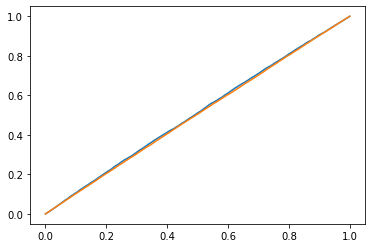

In [213]:
for c in["has_mi","has_hbp","has_VT","has_stroke"]:
    for pheno in pheno_cols:
        pheno += "_adj"
        cond1 = X[pheno] < X[pheno].quantile(0.1)
        cond2 = X[pheno] > X[pheno].quantile(0.9)
        p_low = binom_test(X.loc[cond1,c].sum(),n=cond1.sum(),p=X.loc[~cond1,c].mean())
        p_up = binom_test(X.loc[cond2,c].sum(),n=cond2.sum(),p=X.loc[~cond2,c].mean())
        p_uplow = binom_test(X.loc[cond1,c].sum(),n=cond1.sum(),p=X.loc[cond2,c].mean())
        p_lowup = binom_test(X.loc[cond2,c].sum(),n=cond2.sum(),p=X.loc[cond1,c].mean())
        p_wil = mannwhitneyu(X.loc[X[c],pheno],X.loc[~X[c],pheno])[1]
        if p_low < 1e-2:
            print(c, pheno, "low", p_low)
        if p_up < 1e-2:
            print(c, pheno, "up",p_up)
        if p_uplow < 1e-2:
            print(c, pheno, "uplow",p_uplow)
        if p_lowup < 1e-2:
            print(c, pheno, "lowup",p_lowup)
        if p_wil < 1e-2:
            print(c, pheno, "wil",p_wil)
        if min(p_low,p_up, p_lowup, p_uplow) < 1e-4:
            fpr, tpr, _ = roc_curve(X[c],X[pheno])
            plt.plot(fpr, tpr)

In [228]:
l = pheno_cols + [p+"_adj" for p in pheno_cols] + list(scores_sys.columns)

outcomes = ["has_mi","has_hbp","has_VT","has_stroke","haemo", "thrombosis", "coag_deffect"]

df = pd.DataFrame(index=outcomes)

for pheno in l:
    for c in outcomes:
        cond1 = X[pheno] < X[pheno].quantile(0.1)
        cond2 = X[pheno] > X[pheno].quantile(0.9)
        p_low = binom_test(X.loc[cond1,c].sum(),n=cond1.sum(),p=X.loc[~cond1,c].mean())
        p_up = binom_test(X.loc[cond2,c].sum(),n=cond2.sum(),p=X.loc[~cond2,c].mean())
        p_uplow = binom_test(X.loc[cond1,c].sum(),n=cond1.sum(),p=X.loc[cond2,c].mean())
        p_lowup = binom_test(X.loc[cond2,c].sum(),n=cond2.sum(),p=X.loc[cond1,c].mean())
        p_mann = mannwhitneyu(X.loc[X[c],pheno],X.loc[~X[c],pheno])[1]
        df.loc[c,pheno+"_low"] = p_low
        df.loc[c,pheno+"_up"] = p_up
        df.loc[c,pheno+"_uplow"] = p_uplow
        df.loc[c,pheno+"_lowup"] = p_lowup
        df.loc[c,pheno+"_mann"] = p_mann

In [281]:
mann_tests = [c for c in df.columns if "_mann" in c and "_FIB" in c and "_adj" not in c]
df[mann_tests]

ADP_FIB_mann  CRP_FIB_mann  TRAP_FIB_mann  PAR1_FIB_mann  \
has_mi            0.218642      0.022444       0.000023       0.008742   
has_hbp           0.097883      0.000169       0.056896       0.009728   
has_VT            0.028987      0.021930       0.225064       0.003823   
has_stroke        0.395345      0.049479       0.042316       0.026474   
haemo             0.096161      0.271048       0.113141       0.269585   
thrombosis        0.183203      0.001829       0.062410       0.013479   
coag_deffect      0.298504      0.278112       0.331888       0.163008   

              PAR4_FIB_mann  
has_mi             0.027515  
has_hbp            0.013077  
has_VT             0.006659  
has_stroke         0.013229  
haemo              0.312863  
thrombosis         0.063409  
coag_deffect       0.465393

## Time to event

In [236]:
age = "STROKE_AGE"


9792


In [288]:
for age in ["STROKE_AGE","MI_AGE","HIGH_BP_AGE","VT_AGE","DEATH_AGE","PE_AGE"]:
    c = (~X[age].isnull())
    print(age, c.sum())
    x = X.loc[c]
    lm_classic = LinearRegression().fit(x[scores_sys.columns],x[age])
    y_classic = lm_classic.predict(x[scores_sys.columns])
    #plt.scatter(x[age],y_classic,label="just sysmex%.2f, %.2e" % pearsonr(x[age],y_classic))
    for score in pheno_cols:

        lm_added = LinearRegression().fit(x[list(scores_sys.columns)+[score]],x[age])
        y_added = lm_added.predict(x[list(scores_sys.columns)+[score]])

        rho, p = pearsonr(x[age]-y_classic,x[score])
        print(score, p)
        #rho, p = pearsonr(x[age],y_added)
        #
        #plt.scatter(x[age],y_added,label="Sysmex + %s %.2f, %.2e" % (score, rho, p))
        #plt.legend()

STROKE_AGE 9792
ADP_FIB 0.2450693819670122
CRP_FIB 0.15565196721147395
TRAP_FIB 0.03191262903474595
PAR1_FIB 0.04091565777350348
PAR4_FIB 0.016988131207524133
MI_AGE 15492
ADP_FIB 0.2861360062148356
CRP_FIB 0.518194696653433
TRAP_FIB 0.20202481241923423
PAR1_FIB 0.2599784605156094
PAR4_FIB 0.8178551460307819
HIGH_BP_AGE 102024
ADP_FIB 0.6981938927382898
CRP_FIB 0.5013077650352654
TRAP_FIB 0.3468997994783944
PAR1_FIB 0.2827888003103721
PAR4_FIB 0.4500525859099231
VT_AGE 7511
ADP_FIB 0.25898633539773663
CRP_FIB 0.14835396878567242
TRAP_FIB 0.9047173947554729
PAR1_FIB 0.9790657007844961
PAR4_FIB 0.6316347613961913
DEATH_AGE 14915
ADP_FIB 0.01693543364585553
CRP_FIB 0.7173555722950631
TRAP_FIB 0.3757279759067545
PAR1_FIB 0.616809940871445
PAR4_FIB 0.44674338323158413
PE_AGE 3087
ADP_FIB 0.008759290626386673
CRP_FIB 0.459301512483561
TRAP_FIB 0.40544680044385034
PAR1_FIB 0.01896860642762757
PAR4_FIB 0.07116368569173838


# Unused

## interprétation des prédicteurs, par phénotype.

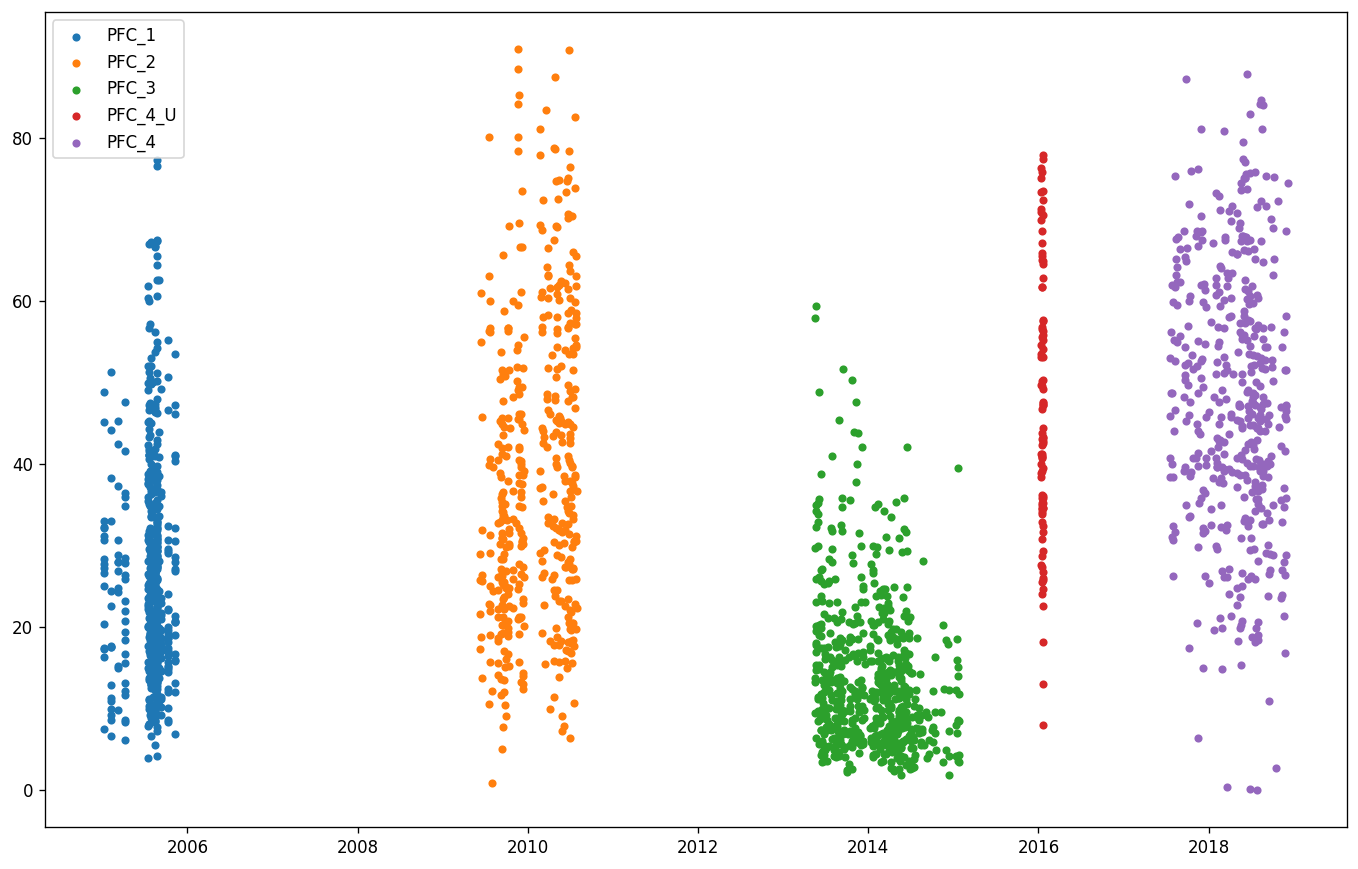

In [329]:
plt.figure(figsize=(14,9),dpi=120)
for project in all_pheno_df.PROJECT.unique():
    cond = all_pheno_df.PROJECT == project
    plt.scatter(all_pheno_df.loc[cond,"DATE"],all_pheno_df.loc[cond,"ADP_FIB_1"],label=project,s=15)
plt.legend()

In [13]:
all_pheno_df.loc[all_pheno_df.PROJECT == "PFC_2"].sample(10)

PROJECT SAMPLE_ID       DATE      TIME  REST_FIB_1  REST_FIB_2  \
854   PFC_2      1417 2010-06-25  10:41:42        6.46        5.35   
638   PFC_2       722 2009-09-22  13:42:41        2.24        1.11   
871   PFC_2       522 2010-07-05  08:08:35        2.91        1.51   
693   PFC_2       787 2009-11-19  08:22:50       26.21        8.90   
884   PFC_2      1294 2010-07-13  11:15:52        3.74        5.63   
814   PFC_2       875 2010-05-21  08:37:10        2.25        2.60   
935   PFC_2      1447 2010-09-07  11:56:41        4.87        4.03   
862   PFC_2       585 2010-06-29  11:01:35        1.51        0.68   
674   PFC_2       520 2009-10-27  11:28:14        3.01        3.61   
701   PFC_2       658 2009-11-24  10:41:57        5.10        2.67   

     REST_PSEL_1  REST_PSEL_2  ADP_FIB_1  ADP_FIB_2  ...  PAR1_PSEL_1  \
854         8.85        10.43      53.47      67.78  ...          NaN   
638         3.52         2.65      12.09      11.77  ...          NaN   
871         8.51         9.62      24.52      36.83  ...          NaN   
693         6.32         6.96      84.17      82.67  ...          NaN   
884        12.34        11.92      53.50      59.37  ...          NaN   
814         7.10         6.53      28.58      34.27  ...          NaN   
935         8.17         6.02      25.81      26.60  ...          NaN   
862         9.05        10.09      19.74      28.03  ...          NaN   
674         6.92         7.23      25.95      30.27  ...          NaN   
701         3.66         3.92      40.56      36.76  ...          NaN   

     PAR1_PSEL_2  PAR4_FIB_1  PAR4_FIB_2  PAR4_PSEL_1  PAR4_PSEL_2  \
854          NaN         NaN         NaN          NaN          NaN   
638          NaN         NaN         NaN          NaN          NaN   
871          NaN         NaN         NaN          NaN          NaN   
693          NaN         NaN         NaN          NaN          NaN   
884          NaN         NaN         NaN          NaN          NaN   
814          NaN         NaN         NaN          NaN          NaN   
935          NaN         NaN         NaN          NaN          NaN   
862          NaN         NaN         NaN          NaN          NaN   
674          NaN         NaN         NaN          NaN          NaN   
701          NaN         NaN         NaN          NaN          NaN   

     TRAP_FIB_1  TRAP_FIB_2  TRAP_PSEL_1  TRAP_PSEL_2  
854         NaN         NaN          NaN          NaN  
638         NaN         NaN          NaN          NaN  
871         NaN         NaN          NaN          NaN  
693         NaN         NaN          NaN          NaN  
884         NaN         NaN          NaN          NaN  
814         NaN         NaN          NaN          NaN  
935         NaN         NaN          NaN          NaN  
862         NaN         NaN          NaN          NaN  
674         NaN         NaN          NaN          NaN  
701         NaN         NaN          NaN          NaN  

[10 rows x 28 columns]

In [22]:
all_pheno_df.loc[all_pheno_df.PROJECT == "PFC_2"].sort_values("DATE").head(15)[["PROJECT","SAMPLE_ID","DATE"]]

PROJECT SAMPLE_ID       DATE
266   PFC_2      1133 2005-08-15
311   PFC_2       534 2005-08-17
312   PFC_2       610 2005-08-17
313   PFC_2       640 2005-08-17
314   PFC_2       643 2005-08-17
315   PFC_2       723 2005-08-17
316   PFC_2       750 2005-08-17
317   PFC_2       921 2005-08-17
318   PFC_2      1154 2005-08-17
515   PFC_2       779 2009-01-10
516   PFC_2      1013 2009-01-10
517   PFC_2      1161 2009-01-10
524   PFC_2      1102 2009-01-12
523   PFC_2      1045 2009-01-12
522   PFC_2      1007 2009-01-12

In [24]:
all_pheno_df.loc[all_pheno_df.PROJECT == "PFC_2"].sort_values("SAMPLE_ID")[["SAMPLE_ID","DATE"]]

SAMPLE_ID       DATE
597      1001 2009-08-27
545      1003 2009-06-16
892      1005 2010-07-20
522      1007 2009-01-12
589      1008 2009-08-26
..        ...        ...
641       992 2009-09-22
728       994 2010-01-07
793       995 2010-04-30
719       996 2009-12-15
945       999 2010-11-03

[450 rows x 2 columns]

## Train on all and save

In [26]:
agg_cols

['high_10_0_wb',
 'high_10_1_wb',
 'high_20_0_wb',
 'high_20_1_wb',
 'high_50_0_wb',
 'high_50_1_wb',
 'low_10_0_wb',
 'low_10_1_wb',
 'low_20_0_wb',
 'low_20_1_wb',
 'low_50_0_wb',
 'low_50_1_wb',
 'mean_0_wb',
 'mean_1_wb',
 'ratio_10_wb',
 'ratio_20_wb',
 'mean_std_0_wb',
 'mean_std_1_wb',
 'mode_0_wb',
 'mode_1_wb',
 'S_0_wb',
 'S_1_wb',
 'iqr_0_wb',
 'iqr_1_wb',
 'corr_wb']

In [27]:
X_info_Y.mean()

high_10_0_wb       0.042774
high_10_1_wb       0.052301
high_20_0_wb       0.054351
high_20_1_wb       0.048367
high_50_0_wb       0.050946
high_50_1_wb       0.051891
low_10_0_wb        0.006725
low_10_1_wb        0.011643
low_20_0_wb        0.000936
low_20_1_wb        0.000094
low_50_0_wb       -0.028676
low_50_1_wb        0.031979
mean_0_wb          0.058504
mean_1_wb          0.030464
ratio_10_wb       -0.064768
ratio_20_wb       -0.066926
mean_std_0_wb      0.041217
mean_std_1_wb      0.032689
mode_0_wb          0.047735
mode_1_wb         -0.003512
S_0_wb            -0.025476
S_1_wb            -0.011358
iqr_0_wb           0.119144
iqr_1_wb          -0.053234
corr_wb            0.008266
MPV_wb             0.037012
PCT_wb             0.014205
PDW_wb             0.126897
PLT_wb             0.053986
PLT_count        259.833021
IPF                3.702251
is_PLT_F           1.000000
MPV               10.340713
PDW               11.979174
PCT                0.260994
FIB               -0

## Check dates of PFC2

In [303]:
pfc2_dates = pd.read_excel("%s/metadata_PF/EE2 Study_Platelet Function_KD_early file.xlsx" % data_dir)
pfc2_dates.SampleID = pfc2_dates.SampleID.astype(str)

In [306]:
all_pheno_df

PROJECT     SAMPLE_ID      DATE  REST_FIB_1  REST_FIB_2  REST_PSEL_1  \
0      PFC_1  100010100138  08/01/05        2.22        2.91          NaN   
1      PFC_1  100010100139  08/01/05        3.22        2.84          NaN   
2      PFC_1  100010100140  08/01/05        3.52        3.28          NaN   
3      PFC_1  100010100141  08/01/05        2.19        2.93          NaN   
4      PFC_1  100010100142  08/01/05        3.60        3.68          NaN   
...      ...           ...       ...         ...         ...          ...   
2137   PFC_4        C1A2PI  28/11/18        0.22        0.36        16.63   
2138   PFC_4        C1A2RE  29/11/18        0.60        0.78        16.23   
2139   PFC_4        C1A2TA  29/11/18        0.32        0.18        11.40   
2140   PFC_4        C1A2X2  30/11/18        0.61        0.37         9.58   
2141   PFC_4        C1A32N  05/12/18        1.39        1.48        12.25   

      REST_PSEL_2  ADP_FIB_1  ADP_FIB_2  CRP_FIB_1  ...  PAR1_PSEL_1  \
0             NaN      30.74      28.15      51.16  ...          NaN   
1             NaN      27.77      25.39      72.27  ...          NaN   
2             NaN      32.35      28.99      47.34  ...          NaN   
3             NaN      27.31      33.07      60.62  ...          NaN   
4             NaN       7.52       8.47      28.44  ...          NaN   
...           ...        ...        ...        ...  ...          ...   
2137        17.23      46.53      45.68      11.31  ...        52.34   
2138        15.65      58.13      57.92      52.53  ...        62.44   
2139        10.59      47.23      41.39       1.66  ...        81.64   
2140         8.33      68.61      67.27      42.16  ...        65.87   
2141        13.04      74.45      76.61      62.99  ...        79.20   

      PAR1_PSEL_2  PAR4_FIB_1  PAR4_FIB_2  PAR4_PSEL_1  PAR4_PSEL_2  \
0             NaN         NaN         NaN          NaN          NaN   
1             NaN         NaN         NaN          NaN          NaN   
2             NaN         NaN         NaN          NaN          NaN   
3             NaN         NaN         NaN          NaN          NaN   
4             NaN         NaN         NaN          NaN          NaN   
...           ...         ...         ...          ...          ...   
2137        52.25       10.62        9.70        51.81        51.21   
2138        68.03       19.76       17.40        67.39        65.58   
2139        81.52       11.15       12.23        50.49        50.53   
2140        66.92       32.51       34.66        58.86        59.99   
2141        79.01       37.87       39.69        72.81        75.02   

      TRAP_FIB_1  TRAP_FIB_2  TRAP_PSEL_1  TRAP_PSEL_2  
0            NaN         NaN          NaN          NaN  
1            NaN         NaN          NaN          NaN  
2            NaN         NaN          NaN          NaN  
3            NaN         NaN          NaN          NaN  
4            NaN         NaN          NaN          NaN  
...          ...         ...          ...          ...  
2137        0.26        0.50        23.14        23.30  
2138        0.92        0.98        18.05        20.74  
2139        1.78        2.72        27.51        33.64  
2140        6.26        5.92        18.91        19.24  
2141        6.17        6.08        36.30        36.20  

[2142 rows x 27 columns]

In [317]:
print(pfc2_dates.shape)
print(all_pheno_df.shape)

m.DATE = pd.to_datetime(m.DATE, format="%d/%m/%y")
print(m.shape)

(450, 3)
(2142, 27)
(450, 30)


Text(0, 0.5, 'Pheno file date')

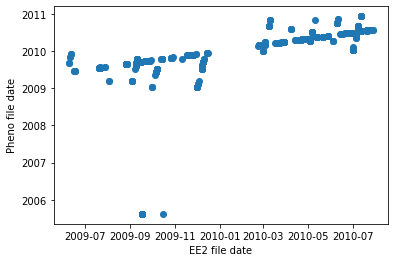

In [320]:
plt.figure()
plt.scatter(m.Date,m.DATE)
plt.xlabel("EE2 file date")
plt.ylabel("Pheno file date")

# Not yet useful

Check if we have the genotype

In [23]:
pfc_4_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home/Genomes/S159_UKBBAffy_v1.0.fam"
gen_ids = pd.read_csv(pfc_4_path, delim_whitespace=True,header=-1)[1].tolist()
print("%d genotypes available for PFC_4 cohort, in %s" % (len(gen_ids),pfc_4_path))

nemunas_data_path = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/Nemunas_data"
matching = pd.read_csv("%s/metadata_PF/Genotyping" % nemunas_data_path,sep="\t")
matching = matching.dropna(how="all",axis=1)
matching = matching.rename(columns={"sampleid of tube":"tube_sample_id",
                                   "Proper Sample ID":"proper_sample_id"})

matching.loc[matching.SAMPLE_ID.isnull(),"SAMPLE_ID"] = \
    matching.loc[matching.SAMPLE_ID.isnull(),"tube_sample_id"]



ValueError: Passing negative integer to header is invalid. For no header, use header=None instead

In [17]:
matching.loc[matching.PROJECT == "PFC4"]

PROJECT SAMPLE_ID RackID     SampleID_2 proper_sample_id Blueprint_ID  \
1919    PFC4    C18967    NaN     S15904007E              NaN          NaN   
1920    PFC4    C18975    NaN     S15901120R              NaN          NaN   
1921    PFC4    C189DU    NaN     S15904639R              NaN          NaN   
1922    PFC4    C189KG    NaN     S15905004N              NaN          NaN   
1923    PFC4    C189UX    NaN  ]C1S15903404Z              NaN          NaN   
1924    PFC4    C189WT    NaN  ]C1S15904414X              NaN          NaN   
1925    PFC4    C18A0F    NaN  ]C1S15903612A              NaN          NaN   
1926    PFC4    C18A1D    NaN  ]C1S15905175Z              NaN          NaN   
1927    PFC4    C18A47    NaN  ]C1S15903640F              NaN          NaN   
1928    PFC4    C18A63    NaN  ]C1S15904638Q              NaN          NaN   
1929    PFC4    C18AFM    NaN  ]C1S15904873W              NaN          NaN   
1930    PFC4    C18AGK    NaN  ]C1S15901392M              NaN          NaN   
1931    PFC4    C18AKC    NaN  ]C1S15900253Z              NaN          NaN   
1932    PFC4    C18AM8    NaN  ]C1S15903975V              NaN          NaN   
1933    PFC4    C18ASX    NaN  ]C1S15902531A              NaN          NaN   
1934    PFC4    C18AWP    NaN  ]C1S15903863Y              NaN          NaN   
1935    PFC4    C18AXN    NaN            NaN              NaN          NaN   
1936    PFC4    C18B19    NaN            NaN              NaN          NaN   
1937    PFC4    C18B27    NaN            NaN              NaN          NaN   
1938    PFC4    C18B43    NaN  ]C1S15903966K              NaN          NaN   
1939    PFC4    C18BBQ    NaN  ]C1S15902081L              NaN          NaN   
1940    PFC4    C18BFI    NaN  ]C1S15905079V              NaN          NaN   
1941    PFC4    C18BQX    NaN  ]C1S15903676V              NaN          NaN   
1942    PFC4    C18BST    NaN  ]C1S15901294F              NaN          NaN   
1943    PFC4    C18BTR    NaN  ]C1S15904313M              NaN          NaN   
1944    PFC4    C18BWL    NaN  ]C1S15902247R              NaN          NaN   
1945    PFC4    C18BXJ    NaN  ]C1S15903412H              NaN          NaN   
1946    PFC4    C18C15    NaN  ]C1S15901164P              NaN          NaN   
1947    PFC4    C18C31    NaN  ]C1S15900269R              NaN          NaN   
1948    PFC4    C18C8S    NaN  ]C1S15901209N              NaN          NaN   
...      ...       ...    ...            ...              ...          ...   
2387    PFC4    C1A09L    NaN  ]C1S15900045Y              NaN          NaN   
2388    PFC4    C1A0BH    NaN  ]C1S15903270D              NaN          NaN   
2389    PFC4    C1A0NU    NaN  ]C1S15904526T              NaN          NaN   
2390    PFC4    C1A0PQ    NaN  ]C1S15901136J              NaN          NaN   
2391    PFC4    C1A0SK    NaN  ]C1S15904451M              NaN          NaN   
2392    PFC4    C1A0UG    NaN  ]C1S15904366V              NaN          NaN   
2393    PFC4    C1A0Y8    NaN  ]C1S15900144F              NaN          NaN   
2394    PFC4    C1A10Z    NaN  ]C1S15900752R              NaN          NaN   
2395    PFC4    C1A14R    NaN  ]C1S15902643X              NaN          NaN   
2396    PFC4    C1A15P    NaN  ]C1S15903770X              NaN          NaN   
2397    PFC4    C1A1AF    NaN  ]C1S15901580R              NaN          NaN   
2398    PFC4    C191D9    NaN  ]C1S15903053S              NaN          NaN   
2399    PFC4    C1A1F5    NaN  ]C1S15905065E              NaN          NaN   
2400    PFC4    C1A1JY    NaN  ]C1S15904328D              NaN          NaN   
2401    PFC4    C1A1Y4    NaN  ]C1S15900245Q              NaN          NaN   
2402    PFC4    C1A21T    NaN  ]C1S15904664T              NaN          NaN   
2403    PFC4    C1A22R    NaN  ]C1S15900803X              NaN          NaN   
2404    PFC4    C1A25L    NaN  ]C1S15903560T              NaN          NaN   
2405    PFC4    C1A27H    NaN  ]C1S15903921L              NaN          NaN   
2406    PFC4    C1A28F    N

In [18]:
pheno_df_w_gen = pd.merge(pheno_df,
                          matching[["SAMPLE_ID","tubeid"]],
                          left_on="SAMPLE_ID",
                          right_on="SAMPLE_ID",how="inner")
pheno_df_w_gen["has_genotype"] = pheno_df_w_gen.tubeid.isin(gen_ids)
print("%d samples for which we have FC measurement and WB also have genotypes" % (pheno_df_w_gen["has_genotype"].sum()))

424 samples for which we have FC measurement and WB also have genotypes


In [20]:
pheno_df_w_gen[["SAMPLE_ID","tubeid","has_genotype"]].to_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home/summaries/wb_fc.csv",index=False)